# Automatic Weather Station Analysis System

This notebook implements a comprehensive analysis system for weather station data, focusing on rainfall, temperature, humidity, and wind measurements. The system provides detailed insights into weather patterns and includes alert mechanisms for extreme conditions.

## System Components
1. Data Collection and Management
2. Weather Parameter Analysis
3. Time Series Visualization
4. Pattern Recognition
5. Alert System

## Data Fields
- **timestamp**: Date and time of measurement
- **rainfall_intensity**: Rainfall intensity (mm/hr)
- **cumulative_rainfall**: Total accumulated rainfall (mm)
- **rainfall_duration**: Duration of rainfall event (hours)
- **temperature**: Air temperature (°C)
- **humidity**: Relative humidity (%)
- **wind_speed**: Wind speed (m/s)

## 1. Setup and Required Libraries

Import necessary libraries and set up the environment for weather data processing and analysis.

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create necessary directories
os.makedirs('data', exist_ok=True)
os.makedirs('data/weather_data', exist_ok=True)

# Define file paths
DATA_FILE = 'data/weather_data/weather_station_data.csv'

print("✓ Libraries imported successfully")
print("✓ Directories created")
print("✓ System initialized")

✓ Libraries imported successfully
✓ Directories created
✓ System initialized


## 2. Data Generation and Management

Create synthetic weather station data with realistic patterns or load existing data. The system simulates hourly readings with realistic weather patterns.

In [2]:
def generate_weather_data(n_samples=168):  # Default to 7 days of hourly data
    """
    Generate synthetic weather station data with realistic patterns.
    Creates hourly readings with seasonal and daily patterns.
    """
    data = {
        'timestamp': [],
        'rainfall_intensity': [],
        'cumulative_rainfall': [],
        'rainfall_duration': [],
        'temperature': [],
        'humidity': [],
        'wind_speed': []
    }
    
    # Generate timestamps (hourly readings)
    end_date = datetime.now()
    start_date = end_date - timedelta(hours=n_samples)
    timestamps = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Base parameters
    base_temp = 25  # Base temperature in celsius
    base_humidity = 60  # Base humidity percentage
    base_wind = 5  # Base wind speed in m/s
    
    cumulative_rain = 0
    current_rain_duration = 0
    rain_event = False
    
    for i in range(n_samples):
        timestamp = timestamps[i]
        hour = timestamp.hour
        day = timestamp.day
        
        # Temperature with daily and random variation
        temp_variation = 5 * np.sin(2 * np.pi * hour / 24)  # Daily cycle
        temp_noise = np.random.normal(0, 2)
        temperature = base_temp + temp_variation + temp_noise
        
        # Humidity inverse to temperature
        humidity_variation = -3 * np.sin(2 * np.pi * hour / 24)
        humidity_noise = np.random.normal(0, 5)
        humidity = base_humidity + humidity_variation + humidity_noise
        humidity = np.clip(humidity, 30, 100)
        
        # Wind speed with daily pattern
        wind_variation = 2 * np.sin(2 * np.pi * hour / 24)
        wind_noise = np.random.normal(0, 1)
        wind_speed = max(0, base_wind + wind_variation + wind_noise)
        
        # Rainfall simulation
        if not rain_event and np.random.random() < 0.1:  # 10% chance of rain starting
            rain_event = True
            current_rain_duration = 0
        elif rain_event and np.random.random() < 0.3:  # 30% chance of rain stopping
            rain_event = False
        
        if rain_event:
            current_rain_duration += 1
            rainfall_intensity = max(0, np.random.normal(5, 2))
            cumulative_rain += rainfall_intensity
        else:
            rainfall_intensity = 0
            current_rain_duration = 0
        
        # Store values
        data['timestamp'].append(timestamp)
        data['rainfall_intensity'].append(rainfall_intensity)
        data['cumulative_rainfall'].append(cumulative_rain)
        data['rainfall_duration'].append(current_rain_duration)
        data['temperature'].append(temperature)
        data['humidity'].append(humidity)
        data['wind_speed'].append(wind_speed)
    
    return pd.DataFrame(data)

def load_or_create_weather_data():
    """
    Load existing weather data or create new synthetic data if file doesn't exist.
    """
    if os.path.exists(DATA_FILE):
        existing_data = pd.read_csv(DATA_FILE)
        existing_data['timestamp'] = pd.to_datetime(existing_data['timestamp'])
        print(f"✓ Loaded existing data: {len(existing_data)} records")
        return existing_data
    else:
        new_data = generate_weather_data()
        new_data.to_csv(DATA_FILE, index=False)
        print(f"✓ Generated new data: {len(new_data)} records")
        return new_data

# Load or generate initial data
df = load_or_create_weather_data()
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nData columns: {df.columns.tolist()}")
df.head()

✓ Loaded existing data: 168 records

Dataset shape: (168, 7)
Date range: 2025-10-11 11:27:37.718382 to 2025-10-18 10:27:37.718382

Data columns: ['timestamp', 'rainfall_intensity', 'cumulative_rainfall', 'rainfall_duration', 'temperature', 'humidity', 'wind_speed']


,timestamp,rainfall_intensity,cumulative_rainfall,rainfall_duration,temperature,humidity,wind_speed
0,2025-10-11 11:27:37.718382,0.0,0.0,0,27.287524,58.532221,6.165327
1,2025-10-11 12:27:37.718382,0.0,0.0,0,28.046060,61.395206,6.010515
2,2025-10-11 13:27:37.718382,0.0,0.0,0,22.766956,63.489257,4.018944
3,2025-10-11 14:27:37.718382,0.0,0.0,0,21.568540,48.437255,4.950370
4,2025-10-11 15:27:37.718382,0.0,0.0,0,19.438804,63.692557,2.677762


## 3. Data Preprocessing and Feature Engineering

Prepare the weather data for analysis by handling missing values, creating derived features, and calculating weather indices.

In [3]:
def preprocess_weather_data(df):
    """
    Preprocess weather data and engineer new features.
    """
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Handle missing values
    numeric_columns = ['rainfall_intensity', 'cumulative_rainfall', 'rainfall_duration', 
                      'temperature', 'humidity', 'wind_speed']
    processed_df[numeric_columns] = processed_df[numeric_columns].fillna(
        processed_df[numeric_columns].mean()
    )
    
    # Add datetime components
    processed_df['hour'] = processed_df['timestamp'].dt.hour
    processed_df['day'] = processed_df['timestamp'].dt.day
    processed_df['month'] = processed_df['timestamp'].dt.month
    processed_df['season'] = (processed_df['month'] % 12 + 3) // 3
    
    # Calculate heat index (when temperature > 20°C and humidity > 40%)
    mask = (processed_df['temperature'] > 20) & (processed_df['humidity'] > 40)
    processed_df['heat_index'] = np.where(mask,
        -8.784695 + 1.61139411 * processed_df['temperature'] + 
        2.338549 * processed_df['humidity'] - 0.14611605 * processed_df['temperature'] * 
        processed_df['humidity'] - 0.012308094 * processed_df['temperature']**2 - 
        0.016424828 * processed_df['humidity']**2 + 0.002211732 * 
        processed_df['temperature']**2 * processed_df['humidity'] + 
        0.00072546 * processed_df['temperature'] * processed_df['humidity']**2 - 
        0.000003582 * processed_df['temperature']**2 * processed_df['humidity']**2,
        processed_df['temperature'])
    
    # Calculate hourly changes
    processed_df['temp_change'] = processed_df['temperature'].diff()
    processed_df['humidity_change'] = processed_df['humidity'].diff()
    processed_df['wind_speed_change'] = processed_df['wind_speed'].diff()
    
    # Calculate moving averages
    processed_df['temp_ma_24h'] = processed_df['temperature'].rolling(window=24).mean()
    processed_df['humidity_ma_24h'] = processed_df['humidity'].rolling(window=24).mean()
    processed_df['wind_speed_ma_24h'] = processed_df['wind_speed'].rolling(window=24).mean()
    
    # Calculate rain intensity categories
    processed_df['rain_intensity_category'] = pd.cut(
        processed_df['rainfall_intensity'],
        bins=[-np.inf, 0, 2.5, 7.5, 15, np.inf],
        labels=['None', 'Light', 'Moderate', 'Heavy', 'Extreme']
    )
    
    # Calculate weather comfort index (simplified)
    processed_df['comfort_index'] = (0.5 * processed_df['temperature'] + 
                                   0.3 * processed_df['humidity'] - 
                                   0.2 * processed_df['wind_speed'])
    
    # Handle any remaining missing values
    processed_df = processed_df.fillna(method='ffill').fillna(method='bfill')
    
    return processed_df

# Process the data
processed_df = preprocess_weather_data(df)
print("✓ Data preprocessing completed")
print(f"\nProcessed features: {len(processed_df.columns)} columns")
print("\nEngineered features:")
print("- Datetime components: hour, day, month, season")
print("- Weather indices: heat_index, comfort_index")
print("- Moving averages: 24-hour moving averages for temperature, humidity, and wind speed")
print("- Change rates: hourly changes in temperature, humidity, and wind speed")
print("- Categories: rain_intensity_category")

processed_df.head()

✓ Data preprocessing completed

Processed features: 20 columns

Engineered features:
- Datetime components: hour, day, month, season
- Weather indices: heat_index, comfort_index
- Moving averages: 24-hour moving averages for temperature, humidity, and wind speed
- Change rates: hourly changes in temperature, humidity, and wind speed
- Categories: rain_intensity_category


,timestamp,rainfall_intensity,cumulative_rainfall,rainfall_duration,temperature,humidity,wind_speed,hour,day,month,season,heat_index,temp_change,humidity_change,wind_speed_change,temp_ma_24h,humidity_ma_24h,wind_speed_ma_24h,rain_intensity_category,comfort_index
0,2025-10-11 11:27:37.718382,0.0,0.0,0,27.287524,58.532221,6.165327,11,11,10,4,28.332708,0.758536,2.862985,-0.154811,25.251533,59.502819,4.894548,None,29.970363
1,2025-10-11 12:27:37.718382,0.0,0.0,0,28.046060,61.395206,6.010515,12,11,10,4,29.677469,0.758536,2.862985,-0.154811,25.251533,59.502819,4.894548,None,31.239489
2,2025-10-11 13:27:37.718382,0.0,0.0,0,22.766956,63.489257,4.018944,13,11,10,4,24.461069,-5.279104,2.094051,-1.991571,25.251533,59.502819,4.894548,None,29.626466
3,2025-10-11 14:27:37.718382,0.0,0.0,0,21.568540,48.437255,4.950370,14,11,10,4,24.970375,-1.198416,-15.052002,0.931425,25.251533,59.502819,4.894548,None,24.325373
4,2025-10-11 15:27:37.718382,0.0,0.0,0,19.438804,63.692557,2.677762,15,11,10,4,19.438804,-2.129737,15.255302,-2.272607,25.251533,59.502819,4.894548,None,28.291617


## 4. Rainfall Analysis

Analyze rainfall patterns including intensity, duration, and accumulation.

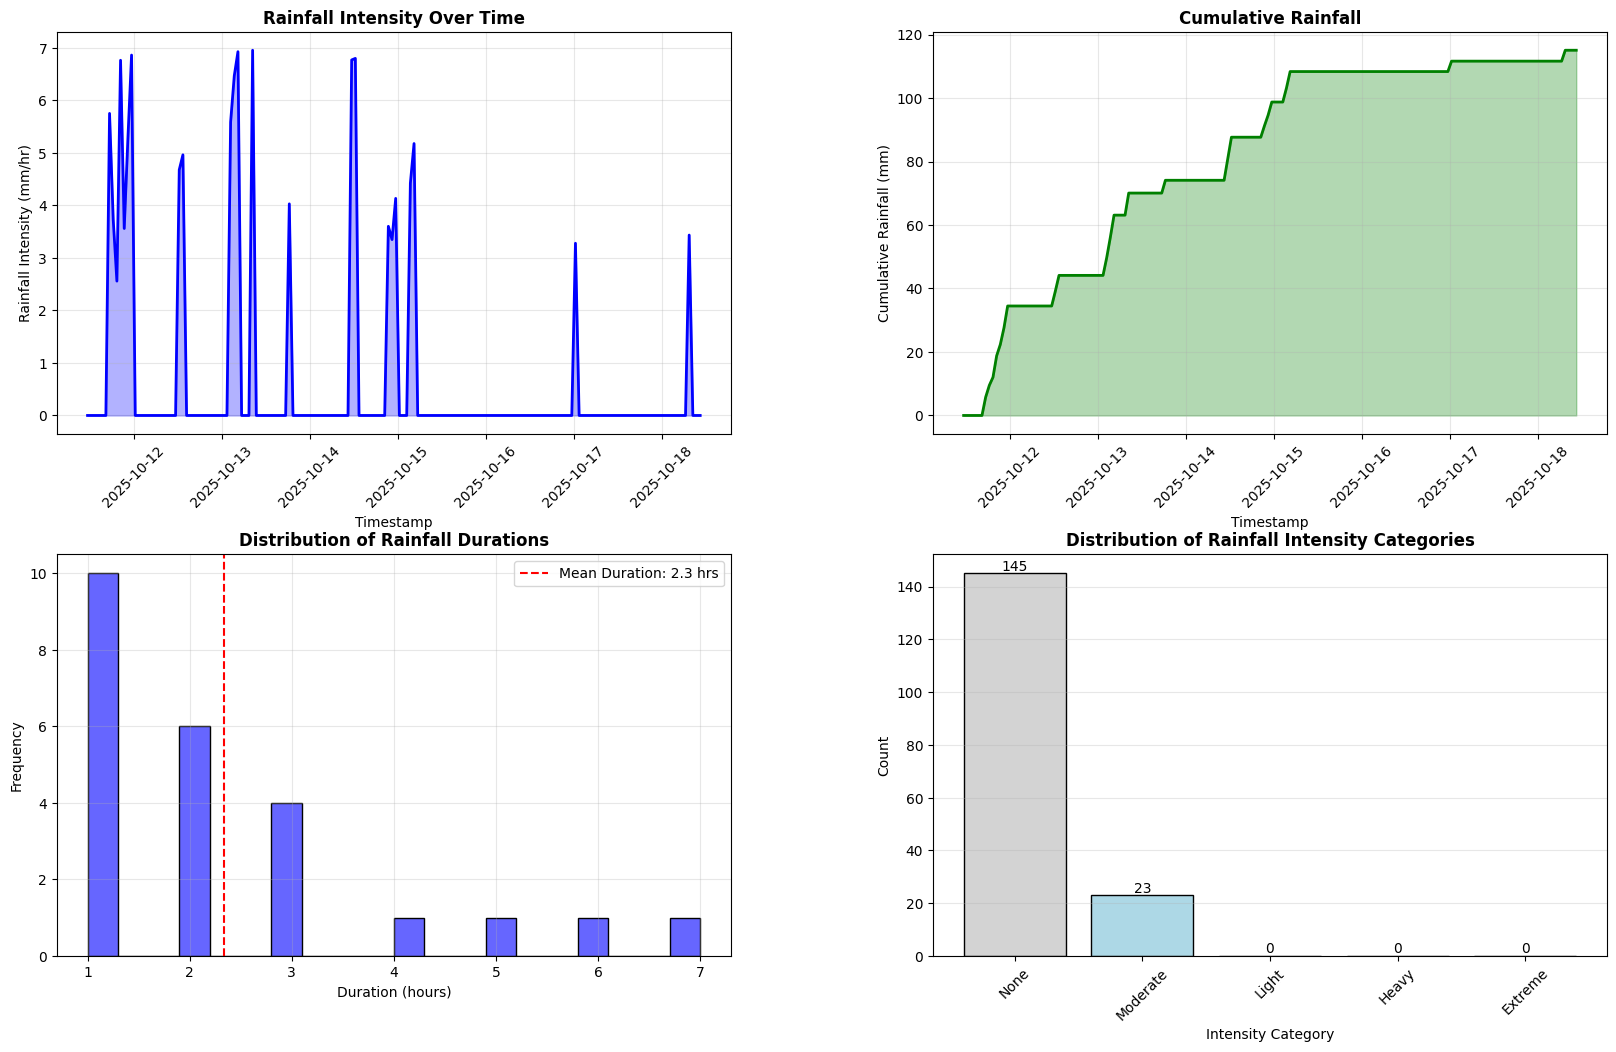


Rainfall Statistics:
--------------------------------------------------
Total Rainfall: 115.1 mm
Maximum Intensity: 7.0 mm/hr
Average Intensity (when raining): 5.0 mm/hr
Number of Rain Events: 23

Rainfall Intensity Categories:
rain_intensity_category
None        145
Moderate     23
Light         0
Heavy         0
Extreme       0


In [4]:
# Create rainfall analysis plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Rainfall Intensity Timeline
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(processed_df['timestamp'], processed_df['rainfall_intensity'],
         color='blue', linewidth=2, label='Intensity')
ax1.fill_between(processed_df['timestamp'], processed_df['rainfall_intensity'],
                 alpha=0.3, color='blue')
ax1.set_title('Rainfall Intensity Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Rainfall Intensity (mm/hr)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Cumulative Rainfall
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(processed_df['timestamp'], processed_df['cumulative_rainfall'],
         color='green', linewidth=2)
ax2.fill_between(processed_df['timestamp'], processed_df['cumulative_rainfall'],
                 alpha=0.3, color='green')
ax2.set_title('Cumulative Rainfall', fontsize=12, fontweight='bold')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Cumulative Rainfall (mm)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Rainfall Duration Distribution
ax3 = fig.add_subplot(gs[1, 0])
rain_durations = processed_df[processed_df['rainfall_duration'] > 0]['rainfall_duration']
if len(rain_durations) > 0:  # Only plot if we have rain events
    sns.histplot(data=rain_durations, bins=20, color='blue', alpha=0.6, ax=ax3)
    ax3.axvline(rain_durations.mean(), color='red', linestyle='--',
                label=f'Mean Duration: {rain_durations.mean():.1f} hrs')
ax3.set_title('Distribution of Rainfall Durations', fontsize=12, fontweight='bold')
ax3.set_xlabel('Duration (hours)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Rainfall Intensity Categories
ax4 = fig.add_subplot(gs[1, 1])
category_counts = processed_df['rain_intensity_category'].value_counts()
colors = ['lightgray', 'lightblue', 'blue', 'darkblue', 'purple']
bars = ax4.bar(category_counts.index, category_counts.values,
               color=colors, edgecolor='black', linewidth=1)
ax4.set_title('Distribution of Rainfall Intensity Categories',
              fontsize=12, fontweight='bold')
ax4.set_xlabel('Intensity Category')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print rainfall statistics
print("\nRainfall Statistics:")
print("-" * 50)
print(f"Total Rainfall: {processed_df['cumulative_rainfall'].max():.1f} mm")
print(f"Maximum Intensity: {processed_df['rainfall_intensity'].max():.1f} mm/hr")
print(f"Average Intensity (when raining): {processed_df[processed_df['rainfall_intensity'] > 0]['rainfall_intensity'].mean():.1f} mm/hr")
print(f"Number of Rain Events: {len(processed_df[processed_df['rainfall_intensity'] > 0])}")
print("\nRainfall Intensity Categories:")
print(processed_df['rain_intensity_category'].value_counts().to_string())

## 5. Temperature and Humidity Analysis

Analyze temperature and humidity patterns, including their relationship and daily cycles.

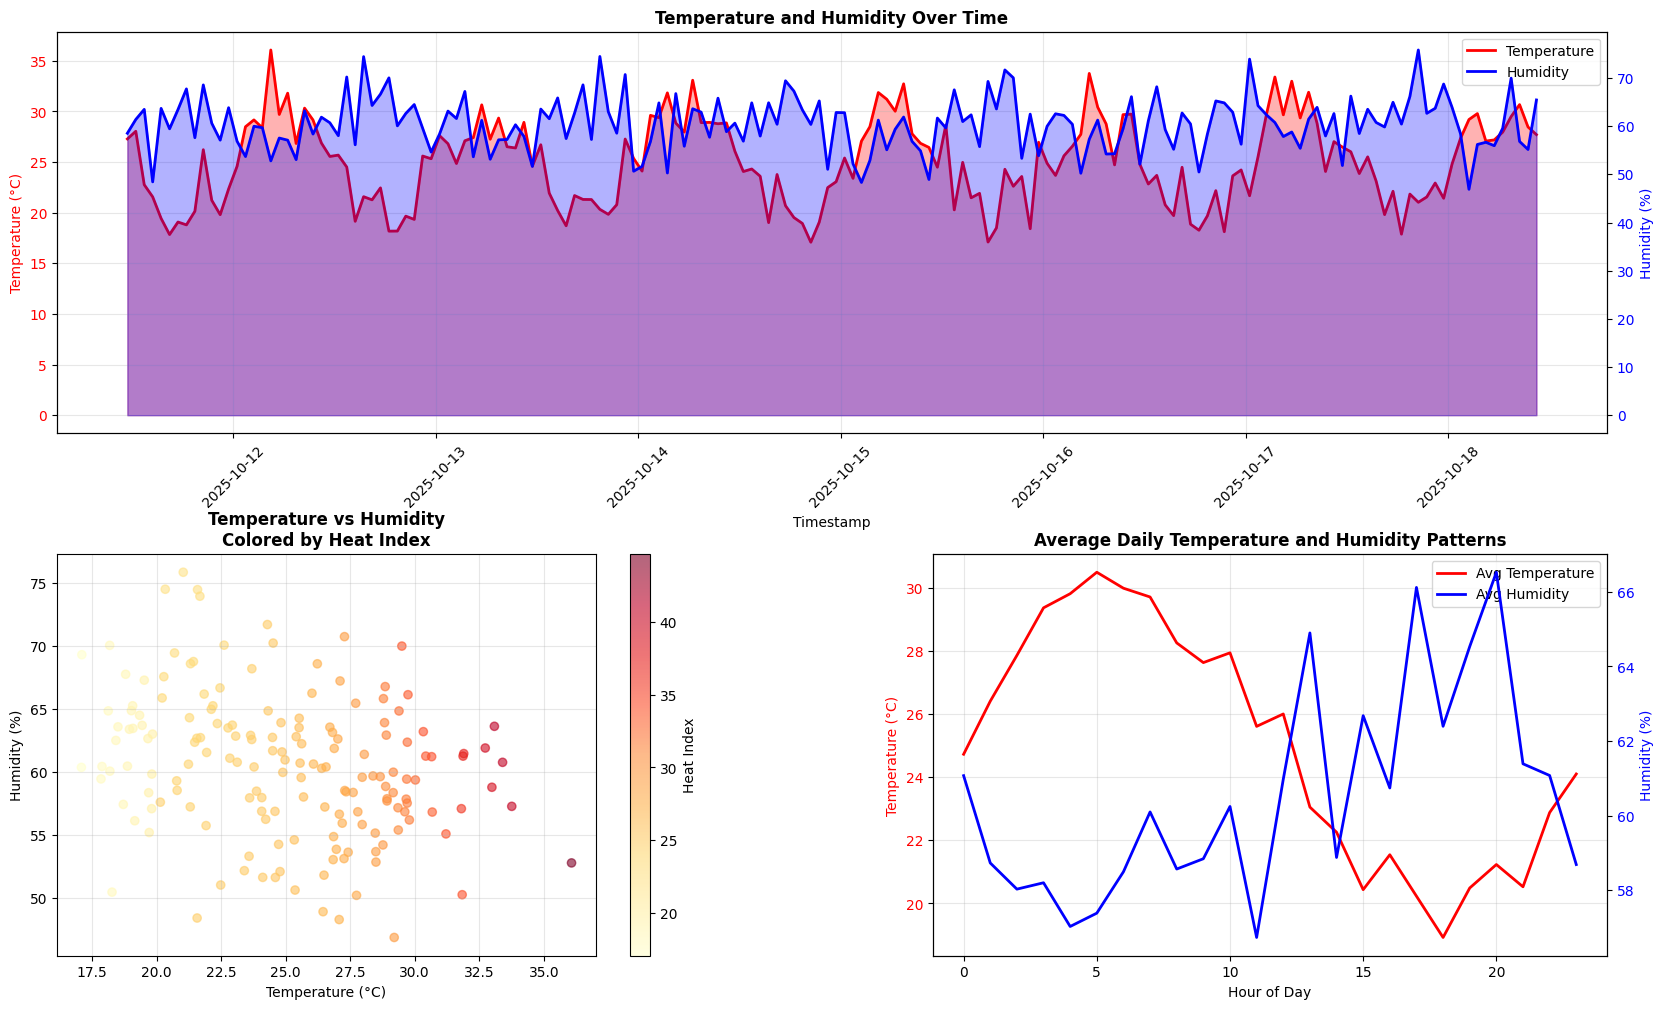


Temperature Statistics:
--------------------------------------------------
Average Temperature: 25.0°C
Maximum Temperature: 36.1°C
Minimum Temperature: 17.1°C
Temperature Range: 19.0°C

Humidity Statistics:
--------------------------------------------------
Average Humidity: 60.5%
Maximum Humidity: 75.8%
Minimum Humidity: 46.9%

Heat Index Statistics:
--------------------------------------------------
Average Heat Index: 26.7°C
Maximum Heat Index: 44.6°C
Hours with Potential Heat Stress (Heat Index > 30°C): 37


In [5]:
# Create temperature and humidity analysis plots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Temperature and Humidity Timeline
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df['timestamp'], processed_df['temperature'],
         color='red', linewidth=2, label='Temperature')
ax1.fill_between(processed_df['timestamp'], processed_df['temperature'],
                 alpha=0.3, color='red')

ax2 = ax1.twinx()
ax2.plot(processed_df['timestamp'], processed_df['humidity'],
         color='blue', linewidth=2, label='Humidity')
ax2.fill_between(processed_df['timestamp'], processed_df['humidity'],
                 alpha=0.3, color='blue')

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Temperature (°C)', color='red')
ax2.set_ylabel('Humidity (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.set_title('Temperature and Humidity Over Time',
              fontsize=12, fontweight='bold')

# 2. Temperature-Humidity Scatter Plot
ax3 = fig.add_subplot(gs[1, 0])
scatter = ax3.scatter(processed_df['temperature'], processed_df['humidity'],
                     c=processed_df['heat_index'], cmap='YlOrRd',
                     alpha=0.6)
plt.colorbar(scatter, ax=ax3, label='Heat Index')
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Humidity (%)')
ax3.set_title('Temperature vs Humidity\nColored by Heat Index',
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 3. Daily Temperature and Humidity Patterns
ax4 = fig.add_subplot(gs[1, 1])
hourly_stats = processed_df.groupby('hour').agg({
    'temperature': 'mean',
    'humidity': 'mean'
}).reset_index()

ax4.plot(hourly_stats['hour'], hourly_stats['temperature'],
         color='red', linewidth=2, label='Avg Temperature')
ax4_twin = ax4.twinx()
ax4_twin.plot(hourly_stats['hour'], hourly_stats['humidity'],
              color='blue', linewidth=2, label='Avg Humidity')

ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Temperature (°C)', color='red')
ax4_twin.set_ylabel('Humidity (%)', color='blue')
ax4.tick_params(axis='y', labelcolor='red')
ax4_twin.tick_params(axis='y', labelcolor='blue')
ax4.grid(True, alpha=0.3)

# Combine legends
lines4, labels4 = ax4.get_legend_handles_labels()
lines4_twin, labels4_twin = ax4_twin.get_legend_handles_labels()
ax4.legend(lines4 + lines4_twin, labels4 + labels4_twin, loc='upper right')
ax4.set_title('Average Daily Temperature and Humidity Patterns',
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print temperature and humidity statistics
print("\nTemperature Statistics:")
print("-" * 50)
print(f"Average Temperature: {processed_df['temperature'].mean():.1f}°C")
print(f"Maximum Temperature: {processed_df['temperature'].max():.1f}°C")
print(f"Minimum Temperature: {processed_df['temperature'].min():.1f}°C")
print(f"Temperature Range: {processed_df['temperature'].max() - processed_df['temperature'].min():.1f}°C")

print("\nHumidity Statistics:")
print("-" * 50)
print(f"Average Humidity: {processed_df['humidity'].mean():.1f}%")
print(f"Maximum Humidity: {processed_df['humidity'].max():.1f}%")
print(f"Minimum Humidity: {processed_df['humidity'].min():.1f}%")

print("\nHeat Index Statistics:")
print("-" * 50)
print(f"Average Heat Index: {processed_df['heat_index'].mean():.1f}°C")
print(f"Maximum Heat Index: {processed_df['heat_index'].max():.1f}°C")
print("Hours with Potential Heat Stress (Heat Index > 30°C):",
      len(processed_df[processed_df['heat_index'] > 30]))

## 6. Wind Speed Analysis

Analyze wind patterns and create wind speed distribution visualizations.

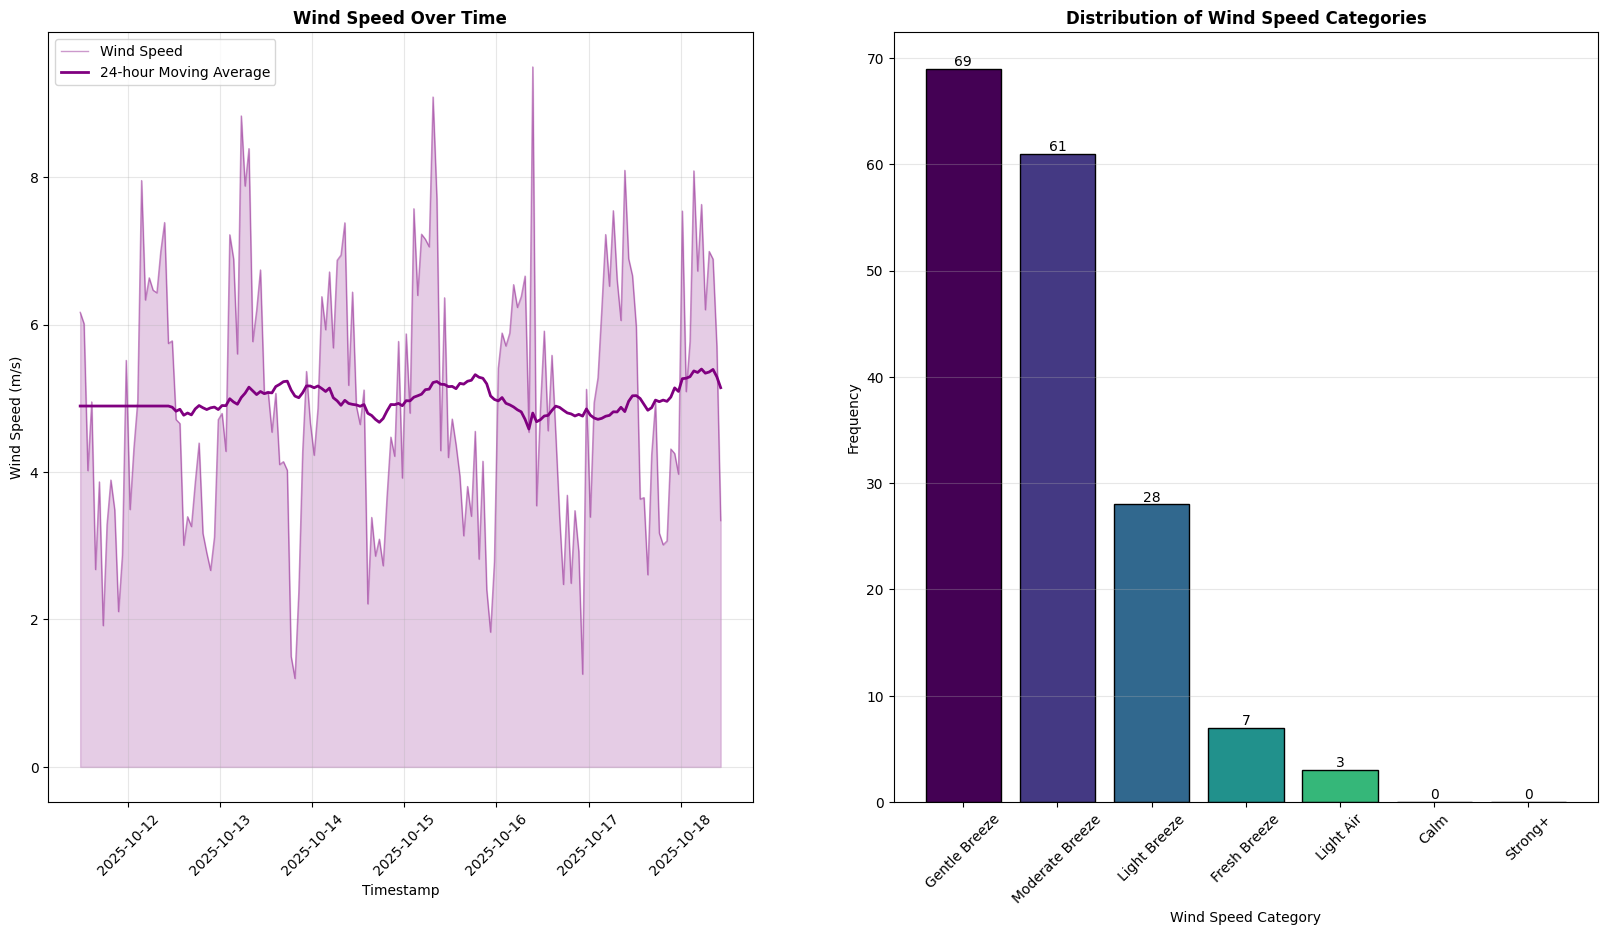

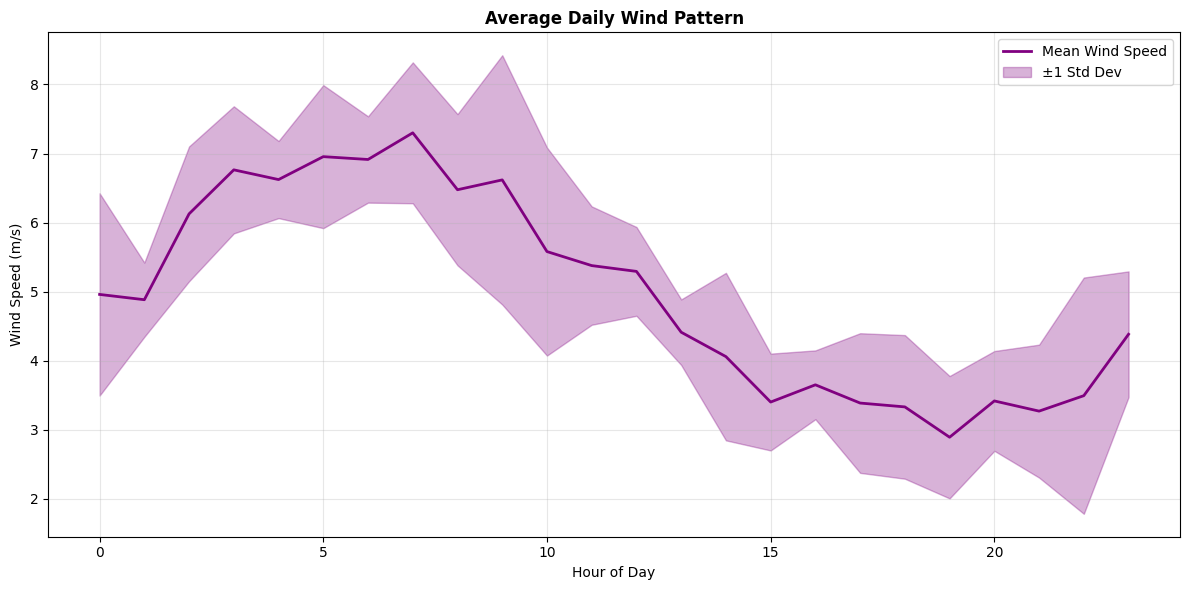


Wind Speed Statistics:
--------------------------------------------------
Average Wind Speed: 5.0 m/s
Maximum Wind Speed: 9.5 m/s
Minimum Wind Speed: 1.2 m/s
Standard Deviation: 1.7 m/s

Wind Speed Categories Distribution:
--------------------------------------------------
wind_speed
Gentle Breeze      69
Moderate Breeze    61
Light Breeze       28
Fresh Breeze        7
Light Air           3
Calm                0
Strong+             0

Wind Speed Percentiles:
--------------------------------------------------
25th percentile: 3.6 m/s
50th percentile: 4.9 m/s
75th percentile: 6.4 m/s
90th percentile: 7.2 m/s
95th percentile: 7.7 m/s


In [6]:
# Create wind speed analysis plots
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.2)

# 1. Wind Speed Timeline with Moving Average
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(processed_df['timestamp'], processed_df['wind_speed'],
         color='purple', alpha=0.4, linewidth=1, label='Wind Speed')
ax1.plot(processed_df['timestamp'], processed_df['wind_speed_ma_24h'],
         color='purple', linewidth=2, label='24-hour Moving Average')
ax1.fill_between(processed_df['timestamp'], processed_df['wind_speed'],
                 alpha=0.2, color='purple')
ax1.set_title('Wind Speed Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Wind Speed (m/s)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# 2. Wind Speed Distribution and Categories
ax2 = fig.add_subplot(gs[0, 1])
# Define wind speed categories
wind_categories = pd.cut(processed_df['wind_speed'],
                        bins=[0, 0.5, 1.5, 3.3, 5.5, 7.9, 10.7, float('inf')],
                        labels=['Calm', 'Light Air', 'Light Breeze', 
                               'Gentle Breeze', 'Moderate Breeze',
                               'Fresh Breeze', 'Strong+'])
wind_dist = wind_categories.value_counts()

colors = plt.cm.viridis(np.linspace(0, 1, len(wind_dist)))
bars = ax2.bar(wind_dist.index, wind_dist.values, color=colors,
               edgecolor='black', linewidth=1)
ax2.set_title('Distribution of Wind Speed Categories',
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Wind Speed Category')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Create daily wind pattern plot
plt.figure(figsize=(12, 6))
hourly_wind = processed_df.groupby('hour')['wind_speed'].agg(['mean', 'std']).reset_index()

plt.plot(hourly_wind['hour'], hourly_wind['mean'],
         color='purple', linewidth=2, label='Mean Wind Speed')
plt.fill_between(hourly_wind['hour'],
                 hourly_wind['mean'] - hourly_wind['std'],
                 hourly_wind['mean'] + hourly_wind['std'],
                 alpha=0.3, color='purple', label='±1 Std Dev')
plt.title('Average Daily Wind Pattern', fontsize=12, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print wind speed statistics
print("\nWind Speed Statistics:")
print("-" * 50)
print(f"Average Wind Speed: {processed_df['wind_speed'].mean():.1f} m/s")
print(f"Maximum Wind Speed: {processed_df['wind_speed'].max():.1f} m/s")
print(f"Minimum Wind Speed: {processed_df['wind_speed'].min():.1f} m/s")
print(f"Standard Deviation: {processed_df['wind_speed'].std():.1f} m/s")

print("\nWind Speed Categories Distribution:")
print("-" * 50)
print(wind_categories.value_counts().to_string())

# Calculate wind speed percentiles
percentiles = [25, 50, 75, 90, 95]
wind_percentiles = np.percentile(processed_df['wind_speed'], percentiles)
print("\nWind Speed Percentiles:")
print("-" * 50)
for p, v in zip(percentiles, wind_percentiles):
    print(f"{p}th percentile: {v:.1f} m/s")

## 7. Weather Parameter Correlations

Analyze relationships between different weather parameters using correlation analysis and visualization.

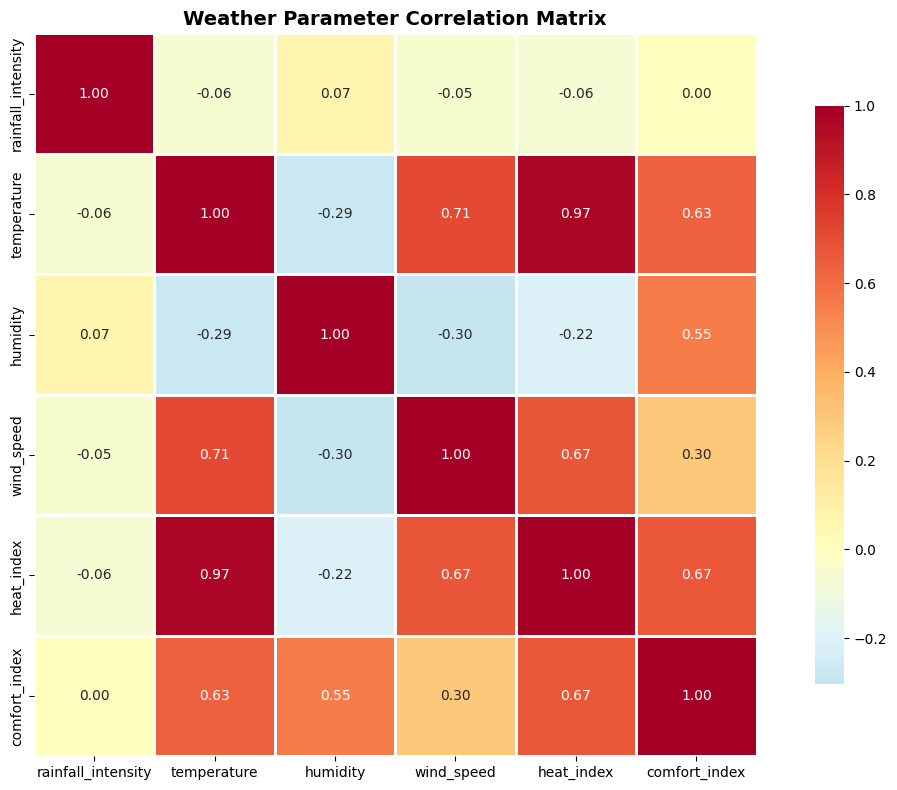

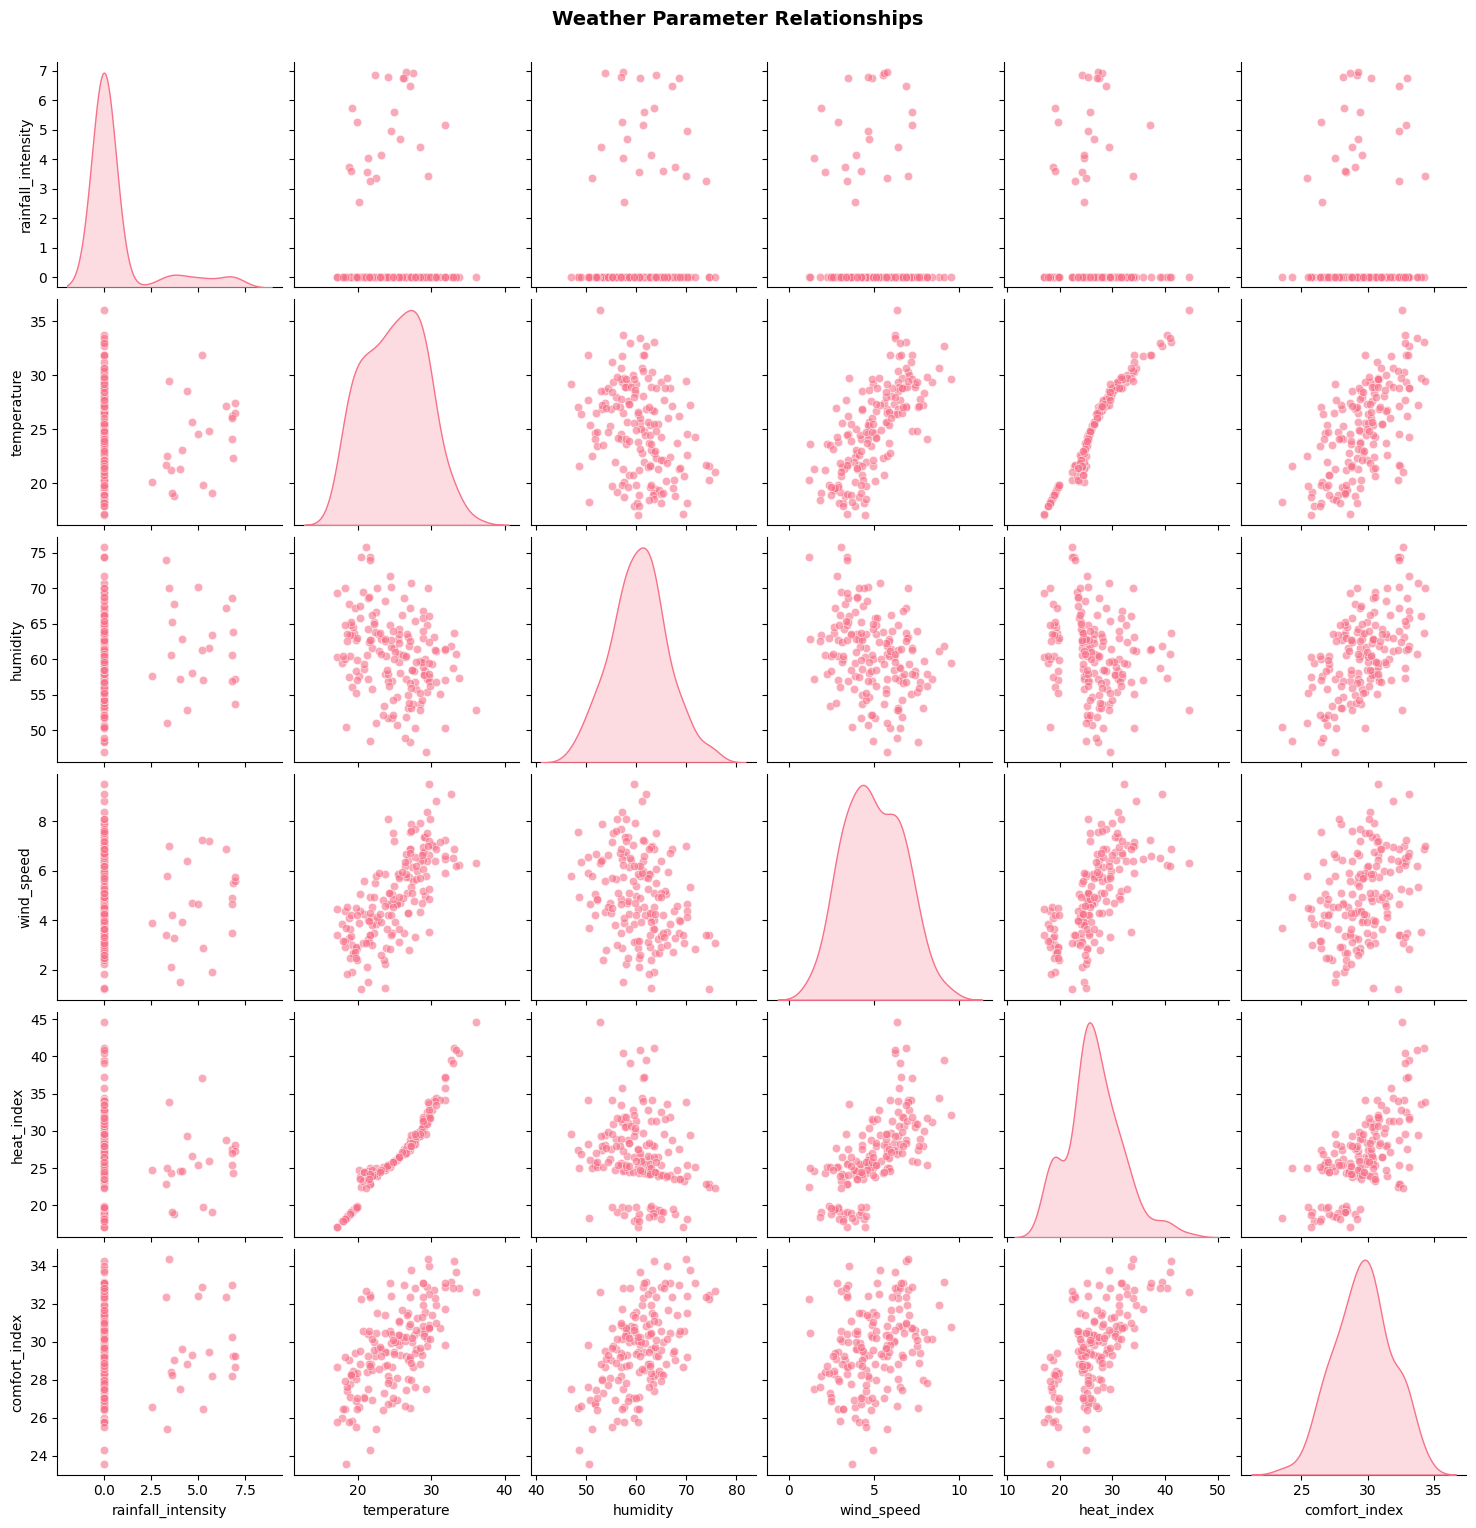


Key Weather Parameter Correlations:
--------------------------------------------------
rainfall_intensity vs temperature: -0.058
rainfall_intensity vs wind_speed: -0.048
temperature vs wind_speed: 0.713
humidity vs rainfall_intensity: 0.069
humidity vs temperature: -0.286
humidity vs wind_speed: -0.303
heat_index vs rainfall_intensity: -0.060
heat_index vs temperature: 0.969
heat_index vs humidity: -0.216
heat_index vs wind_speed: 0.672
comfort_index vs rainfall_intensity: 0.005
comfort_index vs temperature: 0.634
comfort_index vs humidity: 0.551
comfort_index vs wind_speed: 0.296
comfort_index vs heat_index: 0.666

Key Weather Patterns:
--------------------------------------------------
Temperature-Humidity correlation: -0.286
Weak inverse relationship between temperature and humidity

Rainfall-Temperature correlation: -0.058
Weak correlation between rainfall and temperature

Wind-Temperature correlation: 0.713
Significant correlation between wind speed and temperature


In [7]:
# Select relevant columns for correlation analysis
correlation_columns = ['rainfall_intensity', 'temperature', 'humidity', 'wind_speed',
                      'heat_index', 'comfort_index']

# Calculate correlation matrix
correlation_matrix = processed_df[correlation_columns].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.2f', square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Weather Parameter Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Create pairplot for detailed relationship visualization
sns.pairplot(processed_df[correlation_columns], diag_kind='kde',
             plot_kws={'alpha': 0.6})
plt.suptitle('Weather Parameter Relationships', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Calculate and print key correlations
print("\nKey Weather Parameter Correlations:")
print("-" * 50)
for col1 in correlation_columns:
    for col2 in correlation_columns:
        if col1 < col2:  # Avoid printing duplicate correlations
            corr = correlation_matrix.loc[col1, col2]
            print(f"{col1} vs {col2}: {corr:.3f}")

# Analyze specific relationships
print("\nKey Weather Patterns:")
print("-" * 50)

# Temperature-Humidity relationship
temp_humid_corr = np.corrcoef(processed_df['temperature'], processed_df['humidity'])[0,1]
print(f"Temperature-Humidity correlation: {temp_humid_corr:.3f}")
if temp_humid_corr < -0.5:
    print("Strong inverse relationship between temperature and humidity")
elif temp_humid_corr < 0:
    print("Weak inverse relationship between temperature and humidity")
else:
    print("Positive relationship between temperature and humidity")

# Rain-Temperature relationship
rain_temp_corr = np.corrcoef(processed_df['rainfall_intensity'], processed_df['temperature'])[0,1]
print(f"\nRainfall-Temperature correlation: {rain_temp_corr:.3f}")
if abs(rain_temp_corr) > 0.3:
    print("Significant correlation between rainfall and temperature")
else:
    print("Weak correlation between rainfall and temperature")

# Wind-Temperature relationship
wind_temp_corr = np.corrcoef(processed_df['wind_speed'], processed_df['temperature'])[0,1]
print(f"\nWind-Temperature correlation: {wind_temp_corr:.3f}")
if abs(wind_temp_corr) > 0.3:
    print("Significant correlation between wind speed and temperature")
else:
    print("Weak correlation between wind speed and temperature")

## 8. Weather Alert System

Implement a basic weather alert system based on thresholds for different weather parameters.

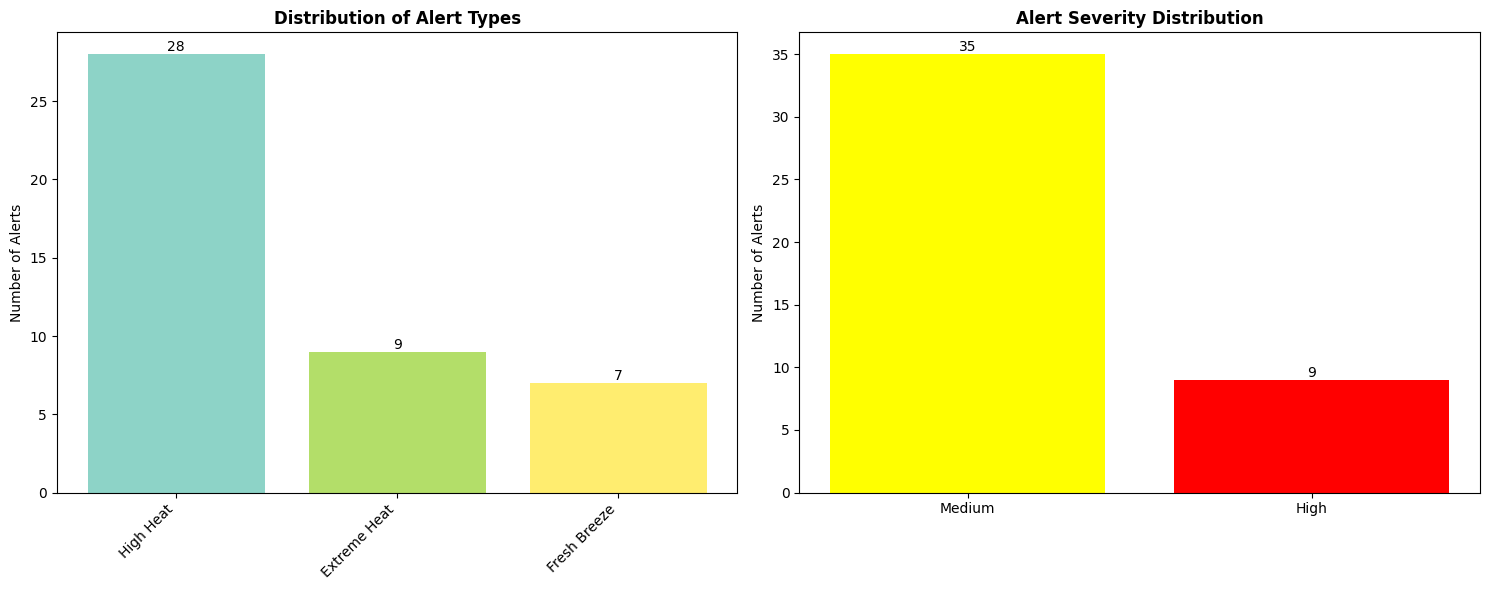

Weather Alert Summary:
--------------------------------------------------
Total number of alerts: 44

Alerts by type:
type
High Heat       28
Extreme Heat     9
Fresh Breeze     7

Alerts by severity:
severity
Medium    35
High       9

Most Recent Alerts:
--------------------------------------------------
[2025-10-18 08:27:37.718382] Medium - High heat conditions: Heat index 33.5°C
[2025-10-18 07:27:37.718382] Medium - High heat conditions: Heat index 33.8°C
[2025-10-18 03:27:37.718382] Medium - Fresh breeze conditions: 8.1 m/s
[2025-10-18 03:27:37.718382] Medium - High heat conditions: Heat index 31.7°C
[2025-10-17 09:27:37.718382] Medium - Fresh breeze conditions: 8.1 m/s


In [8]:
def check_weather_alerts(data):
    """
    Check for weather alerts based on various thresholds.
    Returns a list of alerts and their severity.
    """
    alerts = []
    
    # Rainfall alerts
    if data['rainfall_intensity'] > 15:
        alerts.append({
            'type': 'Extreme Rainfall',
            'severity': 'High',
            'message': f"Extreme rainfall detected: {data['rainfall_intensity']:.1f} mm/hr"
        })
    elif data['rainfall_intensity'] > 7.5:
        alerts.append({
            'type': 'Heavy Rainfall',
            'severity': 'Medium',
            'message': f"Heavy rainfall detected: {data['rainfall_intensity']:.1f} mm/hr"
        })
    
    # Heat index alerts
    if data['heat_index'] > 35:
        alerts.append({
            'type': 'Extreme Heat',
            'severity': 'High',
            'message': f"Dangerous heat conditions: Heat index {data['heat_index']:.1f}°C"
        })
    elif data['heat_index'] > 30:
        alerts.append({
            'type': 'High Heat',
            'severity': 'Medium',
            'message': f"High heat conditions: Heat index {data['heat_index']:.1f}°C"
        })
    
    # Wind speed alerts
    if data['wind_speed'] > 10.7:
        alerts.append({
            'type': 'Strong Winds',
            'severity': 'High',
            'message': f"Strong winds detected: {data['wind_speed']:.1f} m/s"
        })
    elif data['wind_speed'] > 7.9:
        alerts.append({
            'type': 'Fresh Breeze',
            'severity': 'Medium',
            'message': f"Fresh breeze conditions: {data['wind_speed']:.1f} m/s"
        })
    
    # Combined condition alerts
    if data['rainfall_intensity'] > 5 and data['wind_speed'] > 8:
        alerts.append({
            'type': 'Stormy Conditions',
            'severity': 'High',
            'message': "Heavy rain with strong winds detected"
        })
    
    return alerts

# Process alerts for the entire dataset
all_alerts = []
for idx, row in processed_df.iterrows():
    timestamp = row['timestamp']
    alerts = check_weather_alerts(row)
    for alert in alerts:
        alert['timestamp'] = timestamp
        all_alerts.append(alert)

# Convert alerts to DataFrame
alerts_df = pd.DataFrame(all_alerts)

if len(alerts_df) > 0:
    # Plot alert distribution
    plt.figure(figsize=(15, 6))
    
    # Alert counts by type
    plt.subplot(1, 2, 1)
    alert_counts = alerts_df['type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(alert_counts)))
    bars = plt.bar(alert_counts.index, alert_counts.values, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Alert Types', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Alerts')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    # Alert severity distribution
    plt.subplot(1, 2, 2)
    severity_counts = alerts_df['severity'].value_counts()
    colors = {'High': 'red', 'Medium': 'yellow'}
    bars = plt.bar(severity_counts.index, severity_counts.values,
                  color=[colors[s] for s in severity_counts.index])
    plt.title('Alert Severity Distribution', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Alerts')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print alert summary
    print("Weather Alert Summary:")
    print("-" * 50)
    print(f"Total number of alerts: {len(alerts_df)}")
    print(f"\nAlerts by type:")
    print(alerts_df['type'].value_counts().to_string())
    print(f"\nAlerts by severity:")
    print(alerts_df['severity'].value_counts().to_string())
    
    # Print the most recent alerts
    print("\nMost Recent Alerts:")
    print("-" * 50)
    recent_alerts = alerts_df.sort_values('timestamp', ascending=False).head(5)
    for _, alert in recent_alerts.iterrows():
        print(f"[{alert['timestamp']}] {alert['severity']} - {alert['message']}")
else:
    print("No weather alerts generated for the current data.")

## 9. Interactive Time Series Dashboard

Create an interactive dashboard for visualizing all weather parameters using Plotly.

In [9]:
# Create an interactive dashboard using plotly
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Temperature and Heat Index',
        'Rainfall Intensity and Accumulation',
        'Humidity',
        'Wind Speed',
        'Comfort Index',
        'Parameter Correlations'
    ),
    specs=[
        [{"secondary_y": True}, {"secondary_y": True}],
        [{"secondary_y": False}, {"secondary_y": False}],
        [{"secondary_y": False}, {"type": "scatter"}]
    ]
)

# 1. Temperature and Heat Index
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['temperature'],
               name='Temperature', line=dict(color='red')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['heat_index'],
               name='Heat Index', line=dict(color='orange', dash='dash')),
    row=1, col=1
)

# 2. Rainfall
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['rainfall_intensity'],
               name='Rainfall Intensity', line=dict(color='blue')),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['cumulative_rainfall'],
               name='Cumulative Rainfall', line=dict(color='lightblue')),
    row=1, col=2, secondary_y=True
)

# 3. Humidity
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['humidity'],
               name='Humidity', line=dict(color='green')),
    row=2, col=1
)

# 4. Wind Speed
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['wind_speed'],
               name='Wind Speed', line=dict(color='purple')),
    row=2, col=2
)

# 5. Comfort Index
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['comfort_index'],
               name='Comfort Index', line=dict(color='brown')),
    row=3, col=1
)

# 6. Parameter Correlations
# Create correlation scatter between temperature and humidity
fig.add_trace(
    go.Scatter(
        x=processed_df['temperature'],
        y=processed_df['humidity'],
        mode='markers',
        name='Temp-Humidity',
        marker=dict(
            size=8,
            color=processed_df['comfort_index'],
            colorscale='RdYlBu_r',
            showscale=True,
            colorbar=dict(title='Comfort Index')
        )
    ),
    row=3, col=2
)

# Update layout
fig.update_layout(
    height=1000,
    width=1200,
    showlegend=True,
    title_text="Weather Station Dashboard",
    title_x=0.5,
    title_font=dict(size=24)
)

# Update axes labels
fig.update_xaxes(title_text="Timestamp", row=1, col=1)
fig.update_xaxes(title_text="Timestamp", row=1, col=2)
fig.update_xaxes(title_text="Timestamp", row=2, col=1)
fig.update_xaxes(title_text="Timestamp", row=2, col=2)
fig.update_xaxes(title_text="Timestamp", row=3, col=1)
fig.update_xaxes(title_text="Temperature (°C)", row=3, col=2)

fig.update_yaxes(title_text="Temperature (°C)", row=1, col=1)
fig.update_yaxes(title_text="Rainfall Intensity (mm/hr)", row=1, col=2)
fig.update_yaxes(title_text="Cumulative Rainfall (mm)", secondary_y=True, row=1, col=2)
fig.update_yaxes(title_text="Humidity (%)", row=2, col=1)
fig.update_yaxes(title_text="Wind Speed (m/s)", row=2, col=2)
fig.update_yaxes(title_text="Comfort Index", row=3, col=1)
fig.update_yaxes(title_text="Humidity (%)", row=3, col=2)

# Show the interactive dashboard
fig.show()

# Print summary statistics
print("Weather Station Data Summary:")
print("-" * 50)
print(f"Data Period: {processed_df['timestamp'].min()} to {processed_df['timestamp'].max()}")
print(f"Total Records: {len(processed_df)}")
print("\nParameter Ranges:")
print("-" * 50)
for column in ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']:
    data = processed_df[column]
    print(f"\n{column.replace('_', ' ').title()}:")
    print(f"  Min: {data.min():.1f}")
    print(f"  Max: {data.max():.1f}")
    print(f"  Mean: {data.mean():.1f}")
    print(f"  Std Dev: {data.std():.1f}")

# Save the processed data
processed_df.to_csv('data/weather_data/processed_weather_data.csv', index=False)
print("\n✓ Processed data saved to 'data/weather_data/processed_weather_data.csv'")

Weather Station Data Summary:
--------------------------------------------------
Data Period: 2025-10-11 11:27:37.718382 to 2025-10-18 10:27:37.718382
Total Records: 168

Parameter Ranges:
--------------------------------------------------

Temperature:
  Min: 17.1
  Max: 36.1
  Mean: 25.0
  Std Dev: 4.2

Humidity:
  Min: 46.9
  Max: 75.8
  Mean: 60.5
  Std Dev: 5.6

Wind Speed:
  Min: 1.2
  Max: 9.5
  Mean: 5.0
  Std Dev: 1.7

Rainfall Intensity:
  Min: 0.0
  Max: 7.0
  Mean: 0.7
  Std Dev: 1.8

✓ Processed data saved to 'data/weather_data/processed_weather_data.csv'


## 10. Advanced Statistical Analysis

Perform advanced statistical tests and trend analysis on weather data.

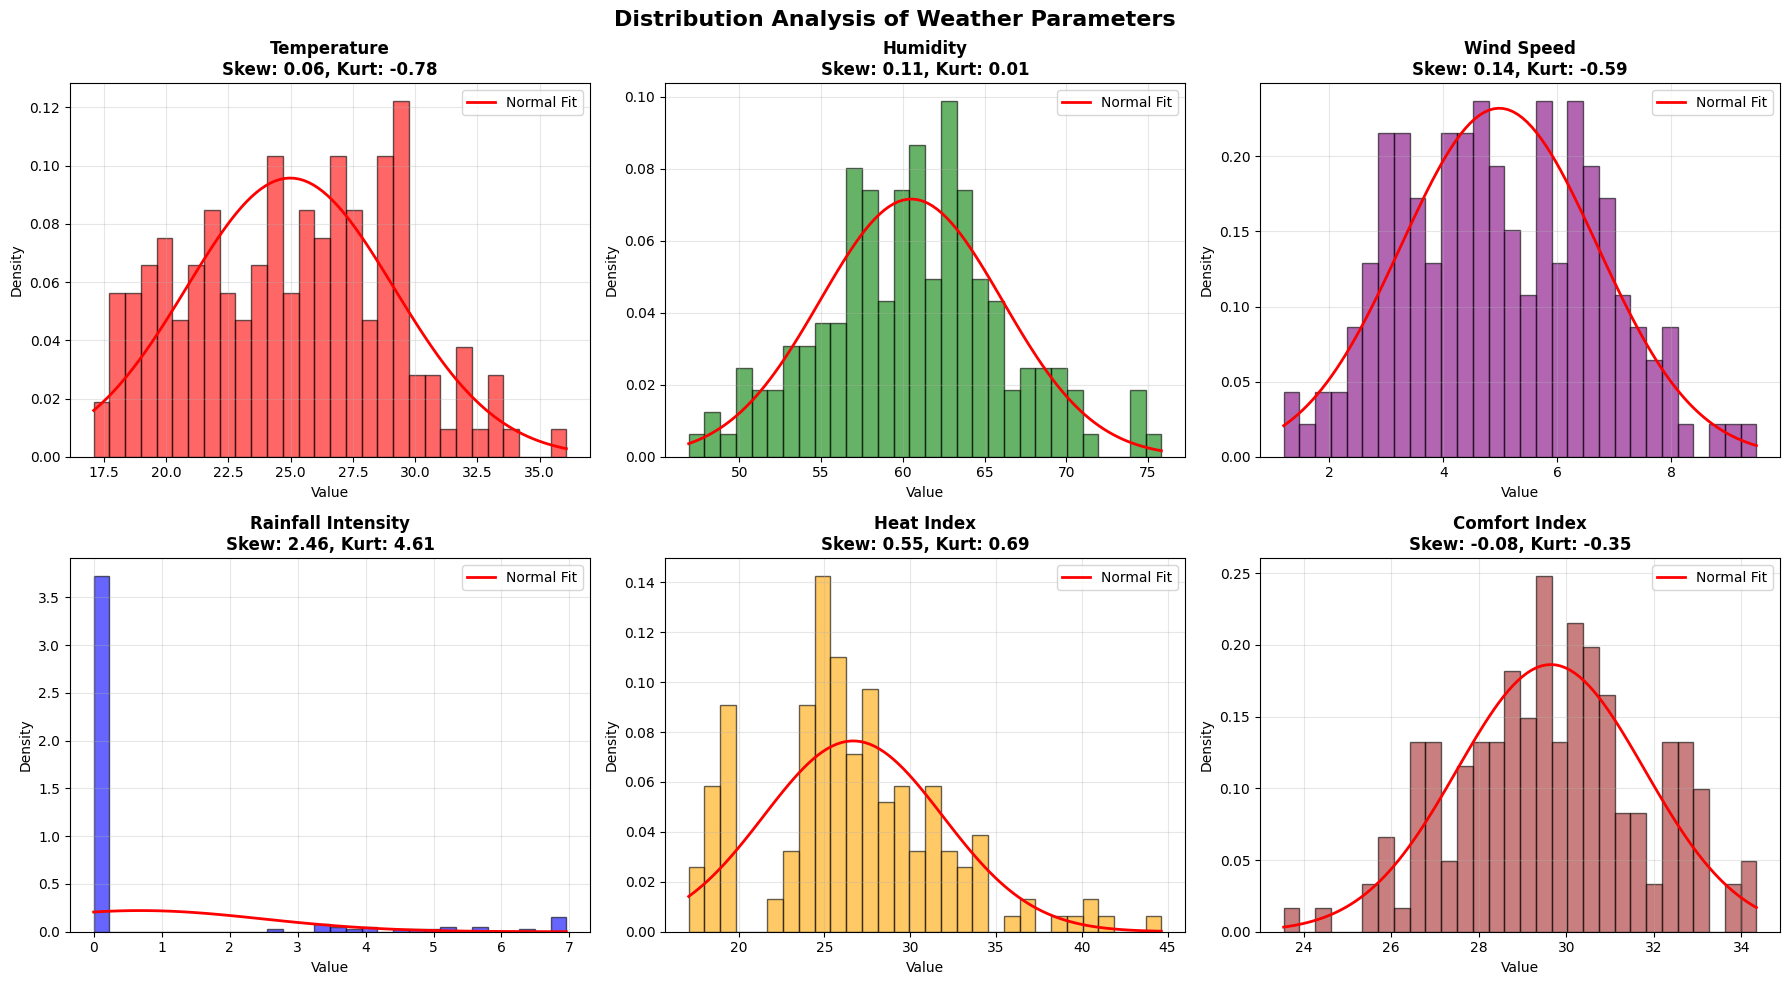

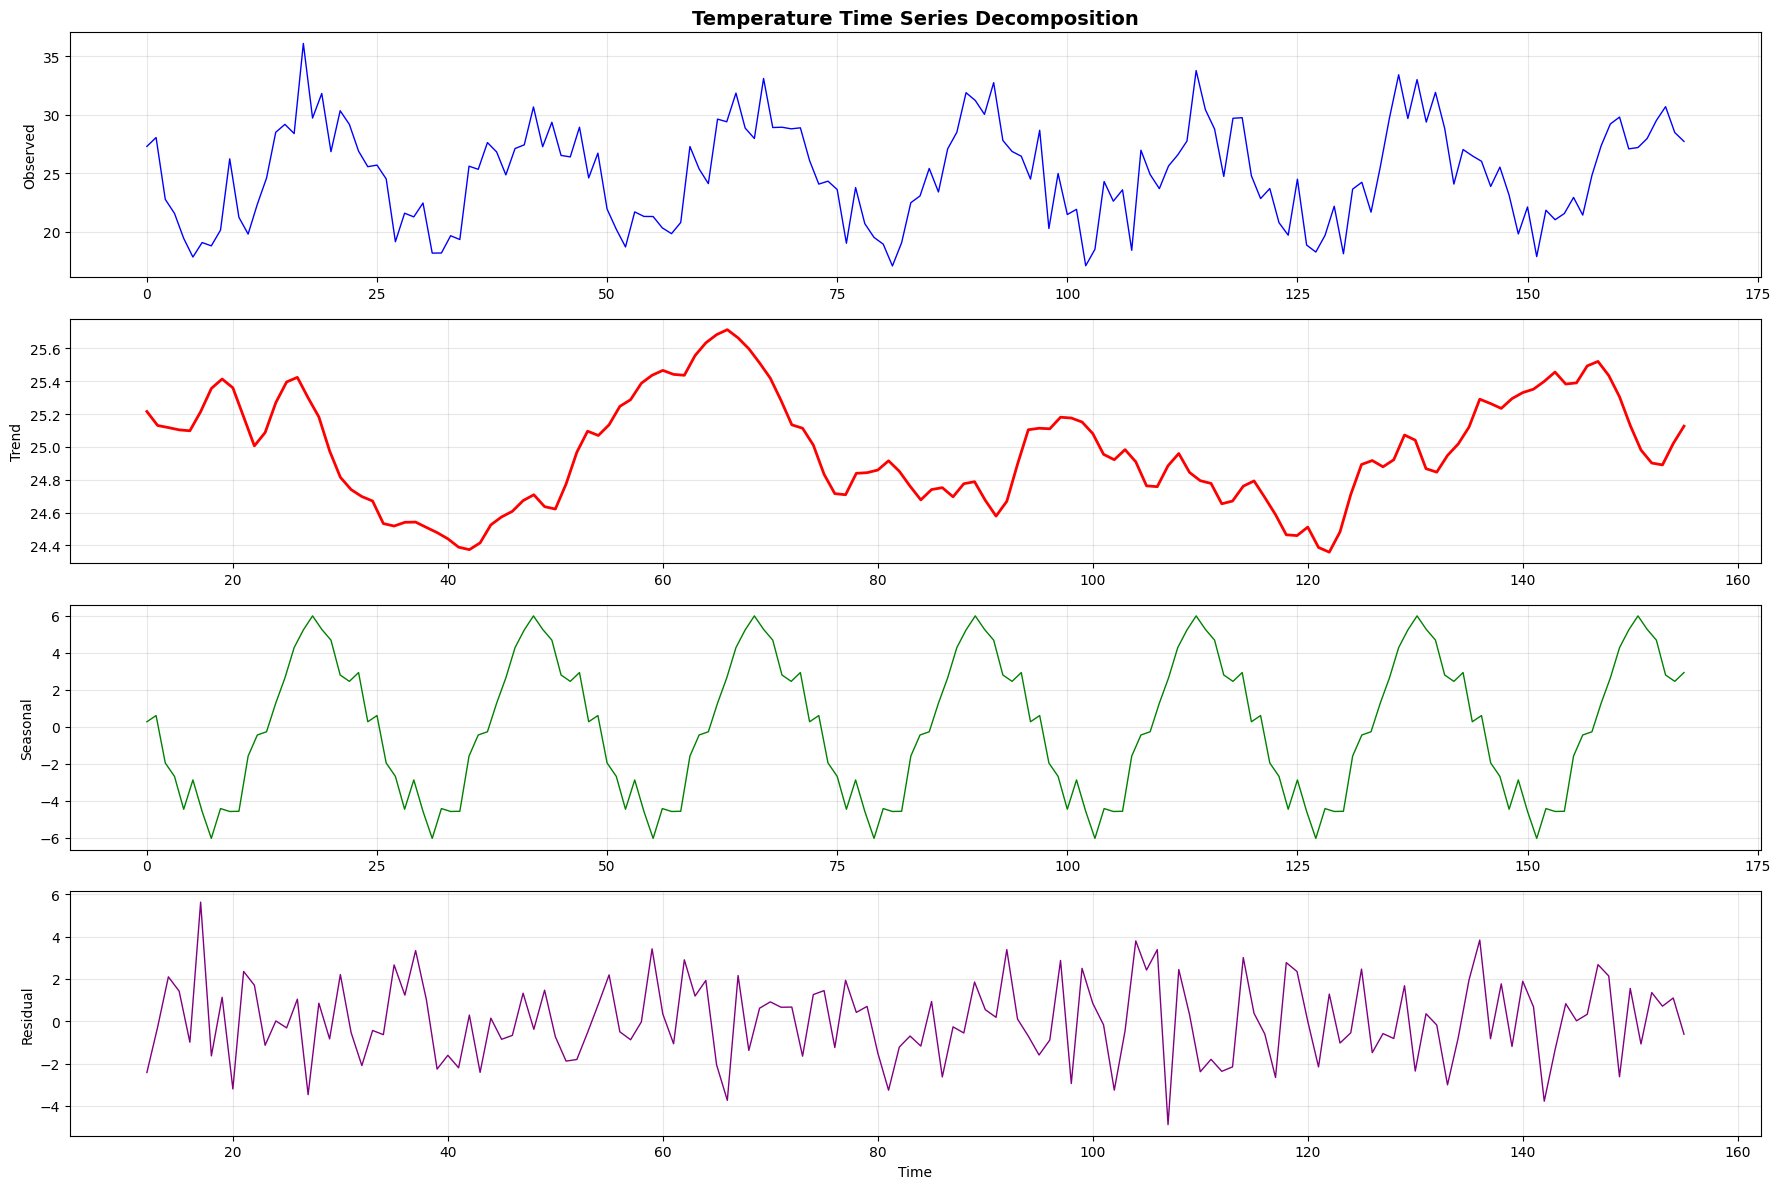

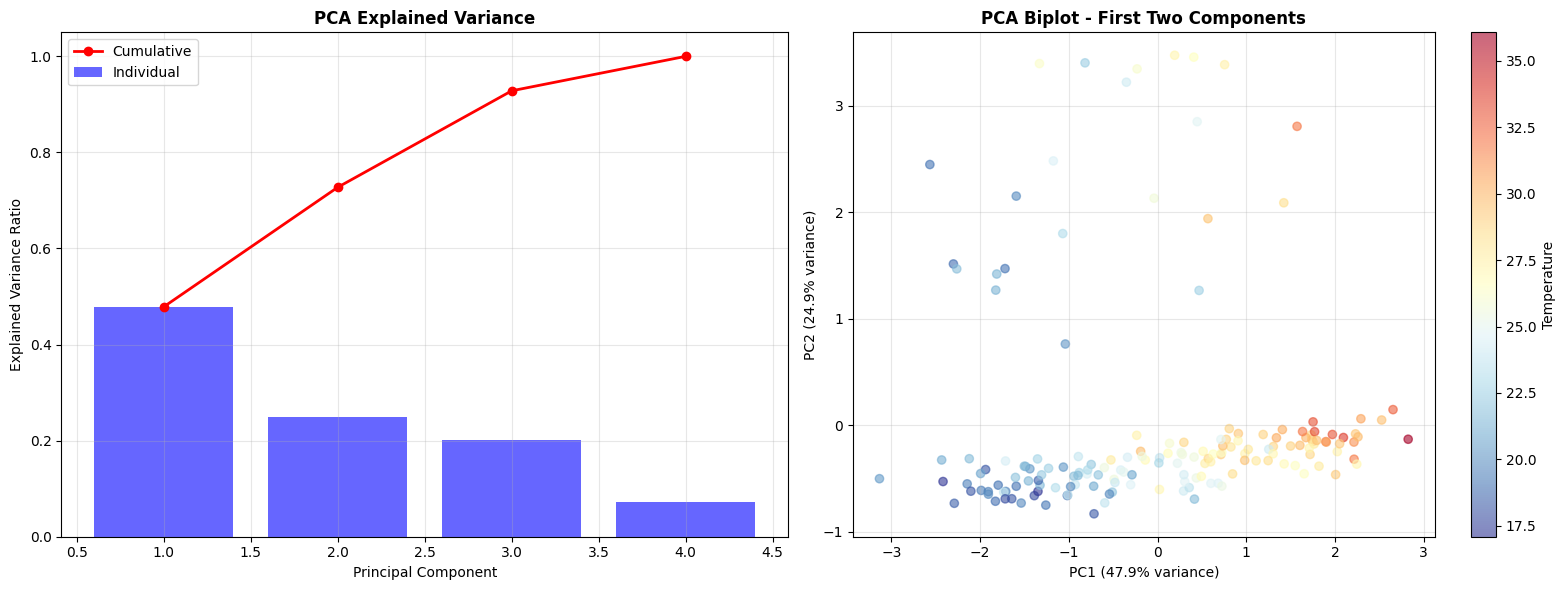

Advanced Statistical Analysis Summary:

Temperature:
  Mean: 24.98
  Median: 24.93
  Std Dev: 4.17
  Skewness: 0.062
  Kurtosis: -0.784
  Normality Test p-value: 0.0052
  Distribution: Non-normal

Humidity:
  Mean: 60.51
  Median: 60.54
  Std Dev: 5.58
  Skewness: 0.112
  Kurtosis: 0.005
  Normality Test p-value: 0.7968
  Distribution: Normal

Wind Speed:
  Mean: 4.98
  Median: 4.87
  Std Dev: 1.72
  Skewness: 0.141
  Kurtosis: -0.592
  Normality Test p-value: 0.0971
  Distribution: Normal

Rainfall Intensity:
  Mean: 0.68
  Median: 0.00
  Std Dev: 1.80
  Skewness: 2.461
  Kurtosis: 4.613
  Normality Test p-value: 0.0000
  Distribution: Non-normal

Heat Index:
  Mean: 26.67
  Median: 25.93
  Std Dev: 5.22
  Skewness: 0.547
  Kurtosis: 0.688
  Normality Test p-value: 0.0038
  Distribution: Non-normal

Comfort Index:
  Mean: 29.65
  Median: 29.61
  Std Dev: 2.14
  Skewness: -0.077
  Kurtosis: -0.351
  Normality Test p-value: 0.6070
  Distribution: Normal

PCA Analysis:
Components needed 

In [4]:
# Advanced Statistical Analysis
from scipy import signal
from scipy.stats import normaltest, skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

params = ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity', 'heat_index', 'comfort_index']
colors = ['red', 'green', 'purple', 'blue', 'orange', 'brown']

for idx, (param, color) in enumerate(zip(params, colors)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    data = processed_df[param].dropna()
    
    # Histogram with KDE
    ax.hist(data, bins=30, density=True, alpha=0.6, color=color, edgecolor='black')
    
    # Fit normal distribution
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Fit')
    
    # Calculate statistics
    skewness = skew(data)
    kurt = kurtosis(data)
    stat, p_value = normaltest(data)
    
    ax.set_title(f'{param.replace("_", " ").title()}\nSkew: {skewness:.2f}, Kurt: {kurt:.2f}',
                fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribution Analysis of Weather Parameters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

fig, axes = plt.subplots(4, 1, figsize=(18, 12))

# Decompose temperature
decomposition = seasonal_decompose(processed_df['temperature'], model='additive', period=24)

axes[0].plot(decomposition.observed, color='blue', linewidth=1)
axes[0].set_ylabel('Observed')
axes[0].set_title('Temperature Time Series Decomposition', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend, color='red', linewidth=2)
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal, color='green', linewidth=1)
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid, color='purple', linewidth=1)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Time')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Principal Component Analysis (PCA)
# Prepare data for PCA
pca_features = ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']
X_pca = processed_df[pca_features].dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

# Create PCA visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Explained variance plot
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

ax1.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.6, color='blue',
        label='Individual')
ax1.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-', linewidth=2,
         label='Cumulative')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PCA biplot
ax2.scatter(principal_components[:, 0], principal_components[:, 1],
           c=processed_df['temperature'][:len(principal_components)],
           cmap='RdYlBu_r', alpha=0.6)
ax2.set_xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
ax2.set_title('PCA Biplot - First Two Components', fontsize=12, fontweight='bold')
plt.colorbar(ax2.collections[0], ax=ax2, label='Temperature')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("Advanced Statistical Analysis Summary:")
print("=" * 80)
for param in params:
    data = processed_df[param].dropna()
    stat, p_value = normaltest(data)
    print(f"\n{param.replace('_', ' ').title()}:")
    print(f"  Mean: {data.mean():.2f}")
    print(f"  Median: {data.median():.2f}")
    print(f"  Std Dev: {data.std():.2f}")
    print(f"  Skewness: {skew(data):.3f}")
    print(f"  Kurtosis: {kurtosis(data):.3f}")
    print(f"  Normality Test p-value: {p_value:.4f}")
    print(f"  Distribution: {'Normal' if p_value > 0.05 else 'Non-normal'}")

print("\n" + "=" * 80)
print("PCA Analysis:")
print(f"Components needed for 95% variance: {np.argmax(cumulative_var >= 0.95) + 1}")
print(f"Total variance explained by first 2 components: {cumulative_var[1]:.1%}")

## 11. Machine Learning Prediction Models

Build predictive models for weather forecasting using advanced ML algorithms.

Training Temperature Prediction Model...
Training Rainfall Event Classifier...


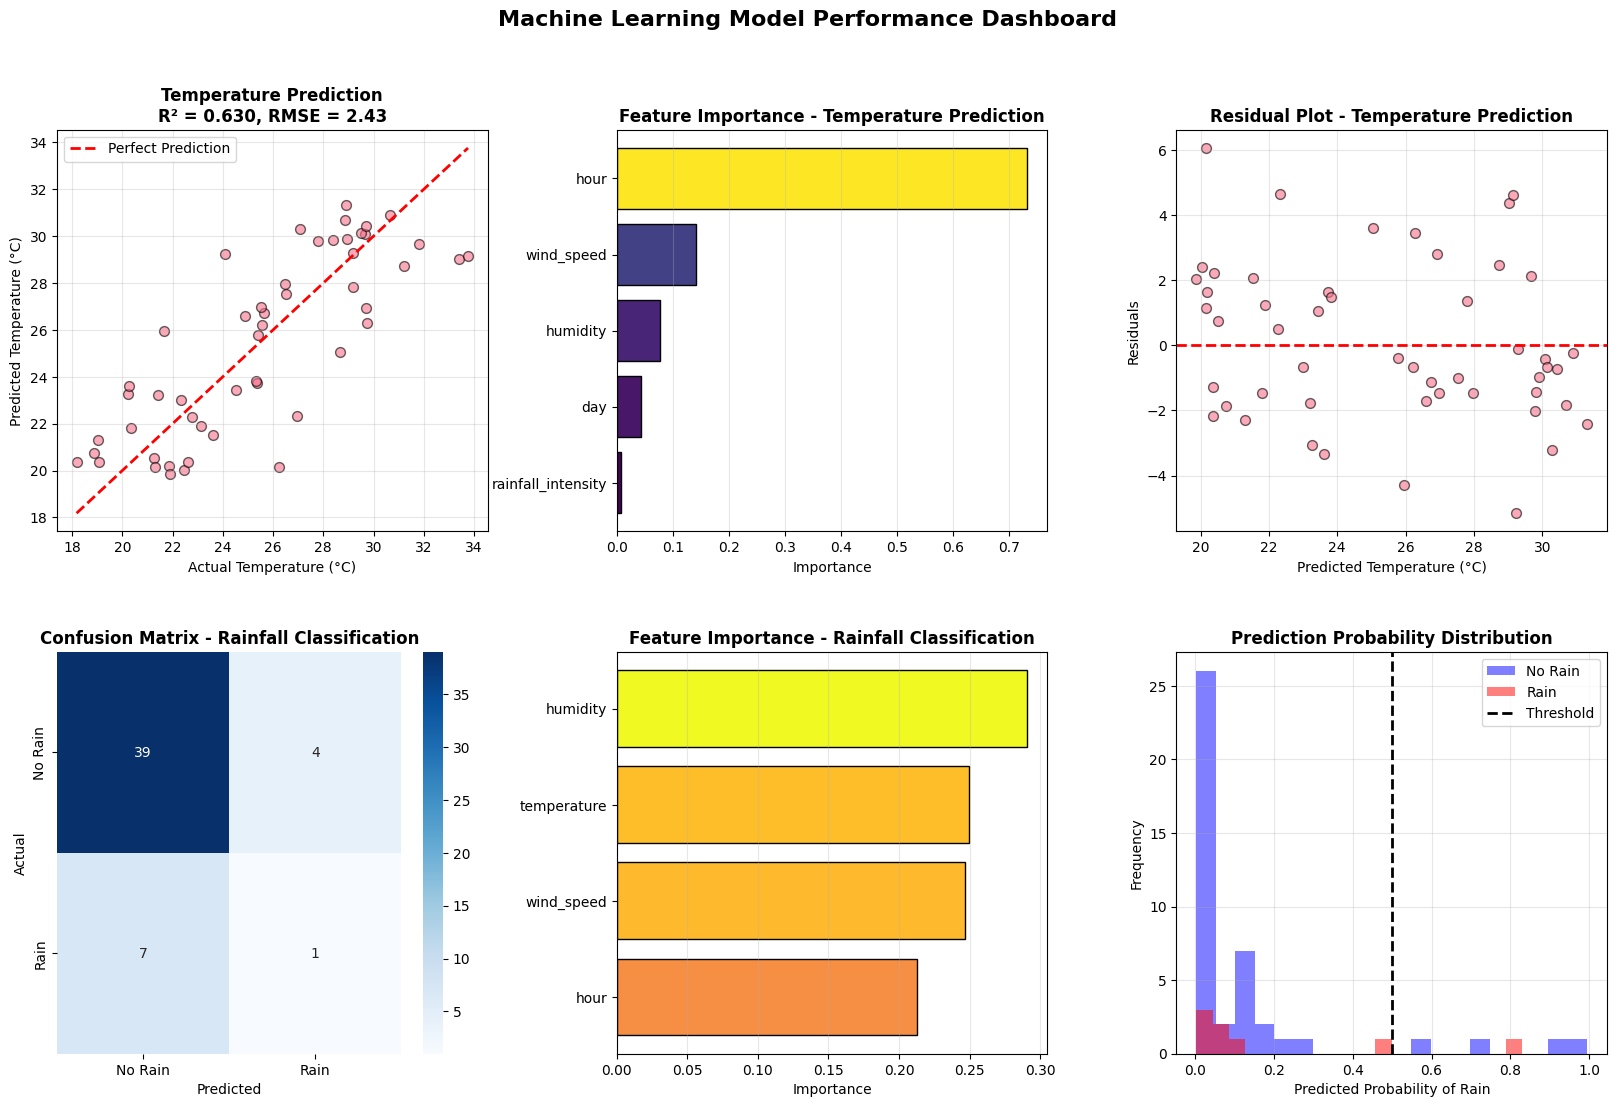


MACHINE LEARNING MODEL PERFORMANCE

🌡️ Temperature Prediction Model (Random Forest):
   R² Score: 0.6303
   RMSE: 2.4261 °C
   Mean Absolute Error: 2.0196 °C
   Cross-validation R² (5-fold): 0.6218 (+/- 0.1550)

🌧️ Rainfall Event Classification Model (Gradient Boosting):
              precision    recall  f1-score   support

     No Rain       0.85      0.91      0.88        43
        Rain       0.20      0.12      0.15         8

    accuracy                           0.78        51
   macro avg       0.52      0.52      0.52        51
weighted avg       0.75      0.78      0.76        51


✓ Models saved successfully!
   Temperature Model: data/weather_data/models/temperature_model.joblib
   Rainfall Classifier: data/weather_data/models/rainfall_classifier.joblib


In [5]:
# Machine Learning Prediction Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import joblib

# Prepare features for prediction
# Task 1: Predict temperature based on other weather parameters
feature_cols = ['humidity', 'wind_speed', 'rainfall_intensity', 'hour', 'day']
target_temp = 'temperature'

# Remove rows with missing values
ml_data = processed_df[feature_cols + [target_temp]].dropna()

X = ml_data[feature_cols]
y_temp = ml_data[target_temp]

# Split data
X_train, X_test, y_train_temp, y_test_temp = train_test_split(
    X, y_temp, test_size=0.3, random_state=42
)

# Train Random Forest model for temperature prediction
print("Training Temperature Prediction Model...")
rf_temp_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_temp_model.fit(X_train, y_train_temp)

# Make predictions
y_pred_temp = rf_temp_model.predict(X_test)

# Calculate metrics
temp_r2 = r2_score(y_test_temp, y_pred_temp)
temp_rmse = np.sqrt(mean_squared_error(y_test_temp, y_pred_temp))

# Task 2: Classify rainfall events
# Create binary classification: rain vs no rain
processed_df['rain_event'] = (processed_df['rainfall_intensity'] > 0).astype(int)

# Prepare data for classification
rain_features = ['temperature', 'humidity', 'wind_speed', 'hour']
rain_data = processed_df[rain_features + ['rain_event']].dropna()

X_rain = rain_data[rain_features]
y_rain = rain_data['rain_event']

X_train_rain, X_test_rain, y_train_rain, y_test_rain = train_test_split(
    X_rain, y_rain, test_size=0.3, random_state=42
)

# Train Gradient Boosting classifier
print("Training Rainfall Event Classifier...")
gb_rain_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_rain_model.fit(X_train_rain, y_train_rain)

# Make predictions
y_pred_rain = gb_rain_model.predict(X_test_rain)
y_pred_rain_proba = gb_rain_model.predict_proba(X_test_rain)

# Visualization of model performance
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Temperature Prediction: Actual vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test_temp, y_pred_temp, alpha=0.6, s=50, edgecolors='black')
ax1.plot([y_test_temp.min(), y_test_temp.max()],
         [y_test_temp.min(), y_test_temp.max()],
         'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Temperature (°C)')
ax1.set_ylabel('Predicted Temperature (°C)')
ax1.set_title(f'Temperature Prediction\nR² = {temp_r2:.3f}, RMSE = {temp_rmse:.2f}',
              fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Temperature Feature Importance
ax2 = fig.add_subplot(gs[0, 1])
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_temp_model.feature_importances_
}).sort_values('importance', ascending=True)

colors_imp = plt.cm.viridis(feature_importance['importance'] / feature_importance['importance'].max())
ax2.barh(feature_importance['feature'], feature_importance['importance'],
         color=colors_imp, edgecolor='black')
ax2.set_xlabel('Importance')
ax2.set_title('Feature Importance - Temperature Prediction', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Residuals Plot
ax3 = fig.add_subplot(gs[0, 2])
residuals = y_test_temp - y_pred_temp
ax3.scatter(y_pred_temp, residuals, alpha=0.6, s=50, edgecolors='black')
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Temperature (°C)')
ax3.set_ylabel('Residuals')
ax3.set_title('Residual Plot - Temperature Prediction', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Rainfall Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
cm = confusion_matrix(y_test_rain, y_pred_rain)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
ax4.set_title('Confusion Matrix - Rainfall Classification', fontweight='bold')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# 5. Rainfall Feature Importance
ax5 = fig.add_subplot(gs[1, 1])
rain_importance = pd.DataFrame({
    'feature': rain_features,
    'importance': gb_rain_model.feature_importances_
}).sort_values('importance', ascending=True)

colors_rain = plt.cm.plasma(rain_importance['importance'] / rain_importance['importance'].max())
ax5.barh(rain_importance['feature'], rain_importance['importance'],
         color=colors_rain, edgecolor='black')
ax5.set_xlabel('Importance')
ax5.set_title('Feature Importance - Rainfall Classification', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# 6. ROC-like visualization
ax6 = fig.add_subplot(gs[1, 2])
# Probability distribution
rain_probs = y_pred_rain_proba[:, 1]
no_rain_idx = y_test_rain == 0
rain_idx = y_test_rain == 1

ax6.hist(rain_probs[no_rain_idx], bins=20, alpha=0.5, label='No Rain', color='blue')
ax6.hist(rain_probs[rain_idx], bins=20, alpha=0.5, label='Rain', color='red')
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax6.set_xlabel('Predicted Probability of Rain')
ax6.set_ylabel('Frequency')
ax6.set_title('Prediction Probability Distribution', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle('Machine Learning Model Performance Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "=" * 80)
print("MACHINE LEARNING MODEL PERFORMANCE")
print("=" * 80)

print("\n🌡️ Temperature Prediction Model (Random Forest):")
print(f"   R² Score: {temp_r2:.4f}")
print(f"   RMSE: {temp_rmse:.4f} °C")
print(f"   Mean Absolute Error: {np.mean(np.abs(residuals)):.4f} °C")

# Cross-validation score
cv_scores = cross_val_score(rf_temp_model, X, y_temp, cv=5, scoring='r2')
print(f"   Cross-validation R² (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n🌧️ Rainfall Event Classification Model (Gradient Boosting):")
print(classification_report(y_test_rain, y_pred_rain, target_names=['No Rain', 'Rain']))

# Save models
os.makedirs('data/weather_data/models', exist_ok=True)
joblib.dump(rf_temp_model, 'data/weather_data/models/temperature_model.joblib')
joblib.dump(gb_rain_model, 'data/weather_data/models/rainfall_classifier.joblib')

print("\n✓ Models saved successfully!")
print("   Temperature Model: data/weather_data/models/temperature_model.joblib")
print("   Rainfall Classifier: data/weather_data/models/rainfall_classifier.joblib")

## 12. Advanced 3D Visualizations and Animations

Create sophisticated 3D visualizations to understand multi-dimensional weather patterns.

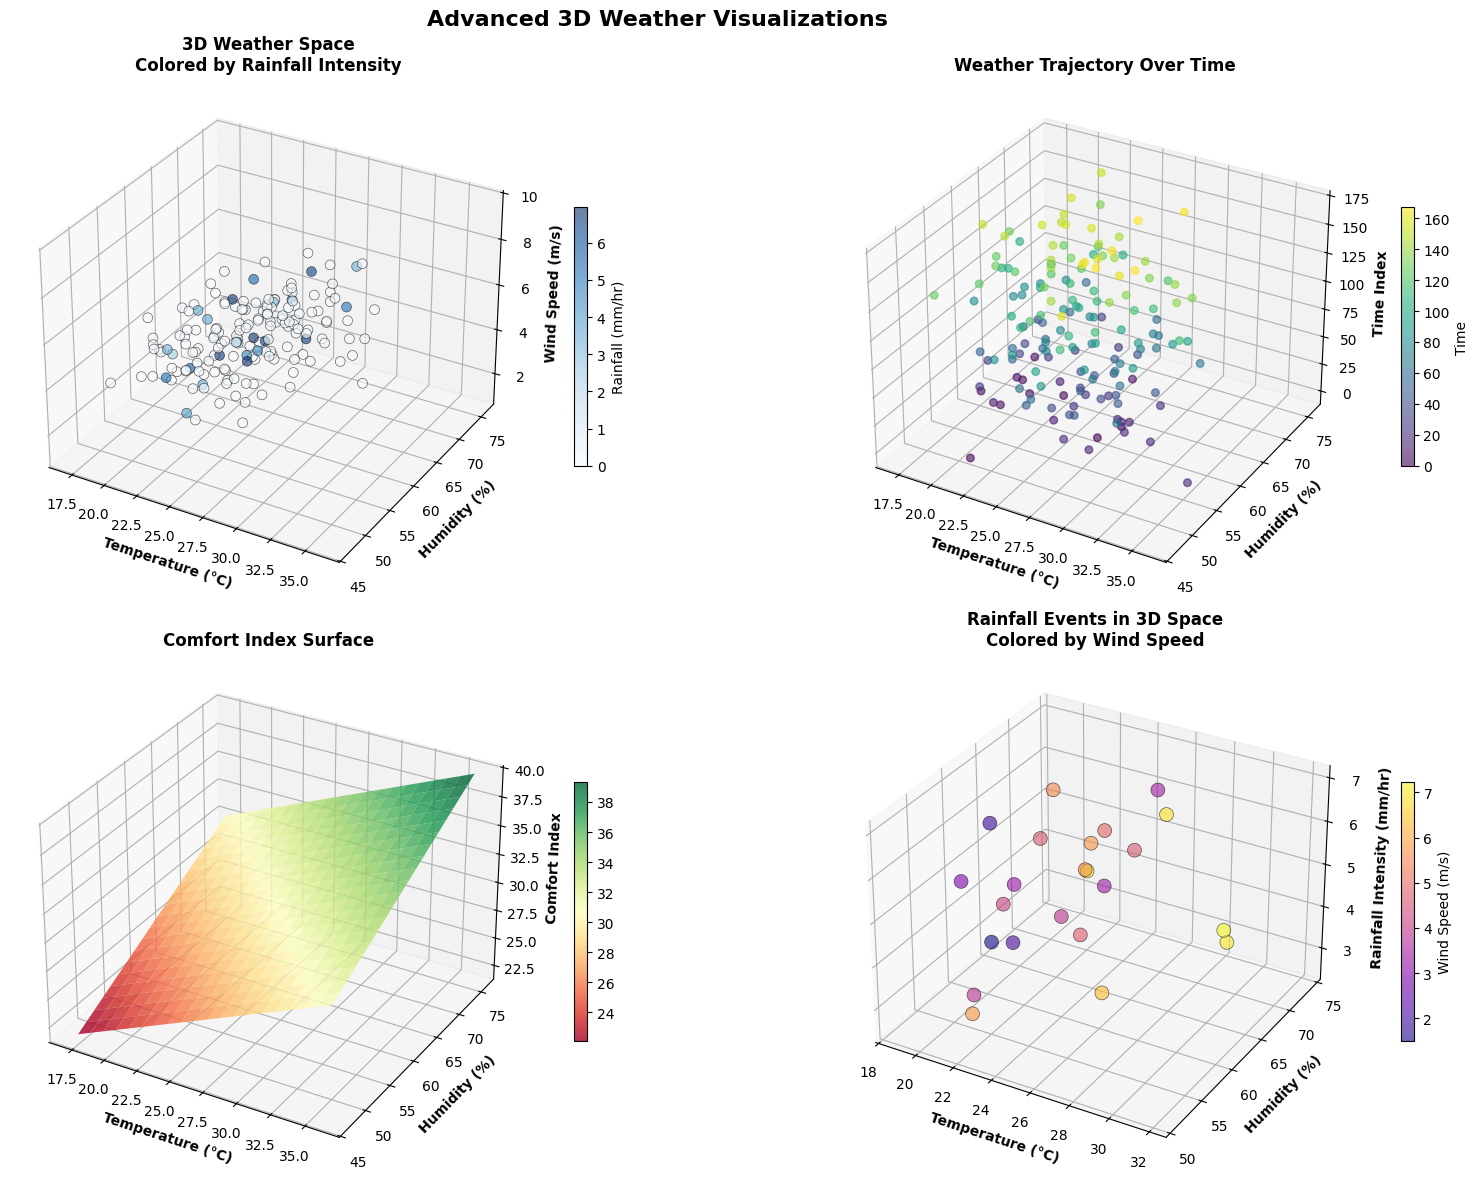

✓ Advanced 3D visualizations created successfully!
  - Static 3D plots show weather space from multiple perspectives
  - Interactive Plotly visualization allows exploration of weather patterns
  - Hover over points in the interactive plot to see detailed information


In [6]:
# Advanced 3D Visualizations
from mpl_toolkits.mplot3d import Axes3D

# 1. 3D Weather Space Visualization
fig = plt.figure(figsize=(18, 12))

# First 3D plot: Temperature, Humidity, Wind Speed
ax1 = fig.add_subplot(221, projection='3d')
scatter1 = ax1.scatter(processed_df['temperature'], processed_df['humidity'],
                       processed_df['wind_speed'],
                       c=processed_df['rainfall_intensity'], cmap='Blues',
                       s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Temperature (°C)', fontweight='bold')
ax1.set_ylabel('Humidity (%)', fontweight='bold')
ax1.set_zlabel('Wind Speed (m/s)', fontweight='bold')
ax1.set_title('3D Weather Space\nColored by Rainfall Intensity', fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Rainfall (mm/hr)', shrink=0.5)

# Second 3D plot: Time-based trajectory
ax2 = fig.add_subplot(222, projection='3d')
# Create time index
time_idx = np.arange(len(processed_df))
scatter2 = ax2.scatter(processed_df['temperature'], processed_df['humidity'],
                       time_idx, c=time_idx, cmap='viridis',
                       s=30, alpha=0.6)
ax2.set_xlabel('Temperature (°C)', fontweight='bold')
ax2.set_ylabel('Humidity (%)', fontweight='bold')
ax2.set_zlabel('Time Index', fontweight='bold')
ax2.set_title('Weather Trajectory Over Time', fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Time', shrink=0.5)

# Third 3D plot: Surface plot of comfort index
ax3 = fig.add_subplot(223, projection='3d')
# Create grid for surface
temp_range = np.linspace(processed_df['temperature'].min(),
                         processed_df['temperature'].max(), 20)
humid_range = np.linspace(processed_df['humidity'].min(),
                          processed_df['humidity'].max(), 20)
T, H = np.meshgrid(temp_range, humid_range)

# Calculate comfort index for grid
C = 0.5 * T + 0.3 * H - 0.2 * processed_df['wind_speed'].mean()

surf = ax3.plot_surface(T, H, C, cmap='RdYlGn', alpha=0.8, edgecolor='none')
ax3.set_xlabel('Temperature (°C)', fontweight='bold')
ax3.set_ylabel('Humidity (%)', fontweight='bold')
ax3.set_zlabel('Comfort Index', fontweight='bold')
ax3.set_title('Comfort Index Surface', fontweight='bold')
plt.colorbar(surf, ax=ax3, shrink=0.5)

# Fourth 3D plot: Rain intensity over time and temperature
ax4 = fig.add_subplot(224, projection='3d')
rain_data = processed_df[processed_df['rainfall_intensity'] > 0]
if len(rain_data) > 0:
    scatter4 = ax4.scatter(rain_data['temperature'], rain_data['humidity'],
                           rain_data['rainfall_intensity'],
                           c=rain_data['wind_speed'], cmap='plasma',
                           s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Temperature (°C)', fontweight='bold')
    ax4.set_ylabel('Humidity (%)', fontweight='bold')
    ax4.set_zlabel('Rainfall Intensity (mm/hr)', fontweight='bold')
    ax4.set_title('Rainfall Events in 3D Space\nColored by Wind Speed', fontweight='bold')
    plt.colorbar(scatter4, ax=ax4, label='Wind Speed (m/s)', shrink=0.5)

plt.suptitle('Advanced 3D Weather Visualizations', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# 2. Interactive 3D Plotly Visualization
fig_3d = go.Figure()

# Add temperature-humidity-wind trace
fig_3d.add_trace(go.Scatter3d(
    x=processed_df['temperature'],
    y=processed_df['humidity'],
    z=processed_df['wind_speed'],
    mode='markers',
    marker=dict(
        size=5,
        color=processed_df['rainfall_intensity'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Rainfall<br>Intensity"),
        line=dict(width=0.5, color='black')
    ),
    text=[f"Time: {t}<br>Temp: {temp:.1f}°C<br>Humidity: {hum:.1f}%<br>Wind: {wind:.1f} m/s<br>Rain: {rain:.1f} mm/hr"
          for t, temp, hum, wind, rain in zip(processed_df['timestamp'],
                                               processed_df['temperature'],
                                               processed_df['humidity'],
                                               processed_df['wind_speed'],
                                               processed_df['rainfall_intensity'])],
    hovertemplate='%{text}<extra></extra>',
    name='Weather Data'
))

fig_3d.update_layout(
    title='Interactive 3D Weather Space Explorer',
    scene=dict(
        xaxis_title='Temperature (°C)',
        yaxis_title='Humidity (%)',
        zaxis_title='Wind Speed (m/s)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    width=900,
    height=700,
    showlegend=True
)

fig_3d.show()

print("✓ Advanced 3D visualizations created successfully!")
print("  - Static 3D plots show weather space from multiple perspectives")
print("  - Interactive Plotly visualization allows exploration of weather patterns")
print("  - Hover over points in the interactive plot to see detailed information")

## 13. Comprehensive Weather Dashboard and Report Generation

Generate a final comprehensive dashboard and detailed system report.

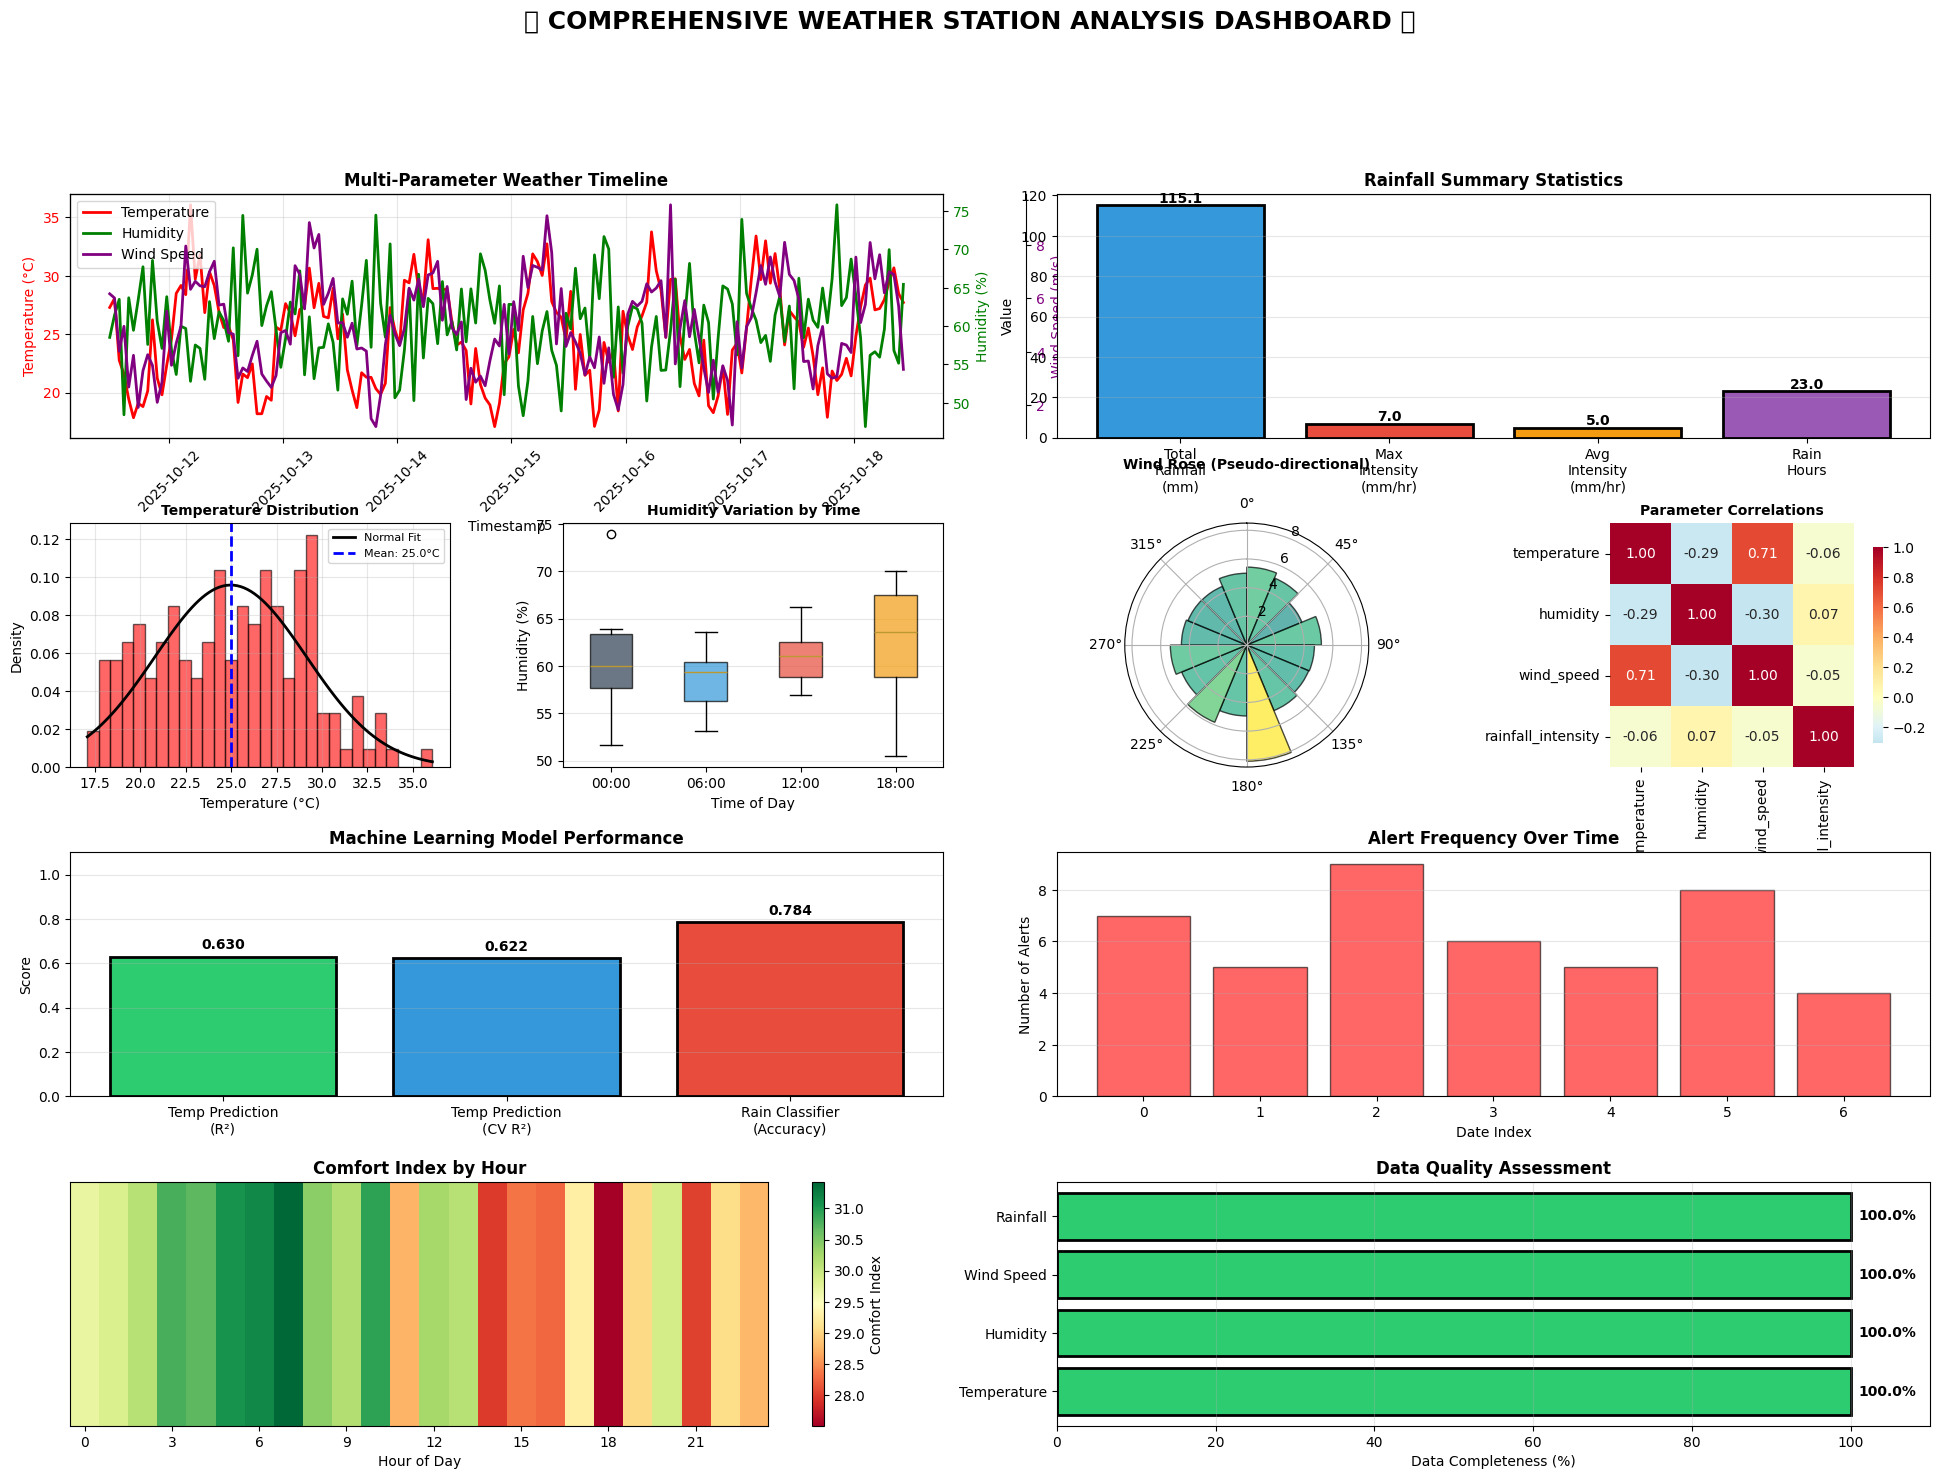

AUTOMATIC WEATHER STATION - COMPREHENSIVE ANALYSIS REPORT

📊 System: Automatic Weather Station Analysis System
⏰ Generated: 2025-10-18 11:34:10

📅 Data Period: 2025-10-11 11:27:37.718382 to 2025-10-18 10:27:37.718382
📈 Total Records: 168
⏱️  Duration: 167.0 hours

WEATHER STATISTICS SUMMARY

TEMPERATURE:
  Mean: 24.98
  Min: 17.09
  Max: 36.07
  Std: 4.17

HUMIDITY:
  Mean: 60.51
  Min: 46.90
  Max: 75.82
  Std: 5.58

WIND_SPEED:
  Mean: 4.98
  Min: 1.20
  Max: 9.49
  Std: 1.72

RAINFALL:
  Total: 115.07
  Max Intensity: 6.95
  Avg Intensity: 5.00
  Rain Hours: 23.00

MACHINE LEARNING MODELS

Temperature Prediction:
  R2 Score: 0.6303
  Rmse: 2.4261
  Cv R2 Mean: 0.6218
  Cv R2 Std: 0.0775

Rainfall Classification:
  Accuracy: 0.7843

ALERT SYSTEM
Total Alerts Generated: 44

Alert Types:
  High Heat: 28
  Extreme Heat: 9
  Fresh Breeze: 7

DATA QUALITY
Temperature Completeness: 100.0%
Humidity Completeness: 100.0%
Wind Speed Completeness: 100.0%
Rainfall Completeness: 100.0%

📄 Full re

In [9]:
# Generate Comprehensive Weather Dashboard and Report
import json

# Create the ultimate dashboard
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)

# 1. Multi-parameter timeline
ax1 = fig.add_subplot(gs[0, :2])
ax1_temp = ax1.twinx()
ax1_rain = ax1.twinx()
ax1_rain.spines['right'].set_position(('outward', 60))

l1 = ax1.plot(processed_df['timestamp'], processed_df['temperature'],
              'r-', linewidth=2, label='Temperature')
l2 = ax1_temp.plot(processed_df['timestamp'], processed_df['humidity'],
                   'g-', linewidth=2, label='Humidity')
l3 = ax1_rain.plot(processed_df['timestamp'], processed_df['wind_speed'],
                   'purple', linewidth=2, label='Wind Speed')

ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Temperature (°C)', color='r')
ax1_temp.set_ylabel('Humidity (%)', color='g')
ax1_rain.set_ylabel('Wind Speed (m/s)', color='purple')
ax1.tick_params(axis='y', labelcolor='r')
ax1_temp.tick_params(axis='y', labelcolor='g')
ax1_rain.tick_params(axis='y', labelcolor='purple')
ax1.tick_params(axis='x', rotation=45)

lns = l1 + l2 + l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
ax1.set_title('Multi-Parameter Weather Timeline', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Rainfall analysis summary
ax2 = fig.add_subplot(gs[0, 2:])
total_rain = processed_df['cumulative_rainfall'].max()
max_intensity = processed_df['rainfall_intensity'].max()
avg_intensity = processed_df[processed_df['rainfall_intensity'] > 0]['rainfall_intensity'].mean()
rain_hours = len(processed_df[processed_df['rainfall_intensity'] > 0])

metrics = ['Total\nRainfall\n(mm)', 'Max\nIntensity\n(mm/hr)', 'Avg\nIntensity\n(mm/hr)', 'Rain\nHours']
values = [total_rain, max_intensity, avg_intensity if not np.isnan(avg_intensity) else 0, rain_hours]
colors_bar = ['#3498DB', '#E74C3C', '#F39C12', '#9B59B6']

bars = ax2.bar(metrics, values, color=colors_bar, edgecolor='black', linewidth=2)
ax2.set_title('Rainfall Summary Statistics', fontweight='bold', fontsize=12)
ax2.set_ylabel('Value')
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Temperature distribution with stats
ax3 = fig.add_subplot(gs[1, 0])
temp_data = processed_df['temperature']
ax3.hist(temp_data, bins=30, density=True, alpha=0.6, color='red', edgecolor='black')
mu, sigma = temp_data.mean(), temp_data.std()
x = np.linspace(temp_data.min(), temp_data.max(), 100)
ax3.plot(x, stats.norm.pdf(x, mu, sigma), 'k-', linewidth=2, label='Normal Fit')
ax3.axvline(mu, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mu:.1f}°C')
ax3.set_xlabel('Temperature (°C)')
ax3.set_ylabel('Density')
ax3.set_title('Temperature Distribution', fontweight='bold', fontsize=10)
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Humidity box plot by hour
ax4 = fig.add_subplot(gs[1, 1])
hourly_humidity = [processed_df[processed_df['hour'] == h]['humidity'].values
                   for h in [0, 6, 12, 18]]
bp = ax4.boxplot(hourly_humidity, labels=['00:00', '06:00', '12:00', '18:00'],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], ['#2C3E50', '#3498DB', '#E74C3C', '#F39C12']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_xlabel('Time of Day')
ax4.set_ylabel('Humidity (%)')
ax4.set_title('Humidity Variation by Time', fontweight='bold', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Wind speed polar plot
ax5 = fig.add_subplot(gs[1, 2], projection='polar')
# Create pseudo wind direction data (for demonstration)
wind_directions = np.random.uniform(0, 2*np.pi, len(processed_df))
wind_speeds = processed_df['wind_speed'].values

# Bin by direction
n_bins = 16
theta_bins = np.linspace(0, 2*np.pi, n_bins + 1)
wind_by_direction = []
for i in range(n_bins):
    mask = (wind_directions >= theta_bins[i]) & (wind_directions < theta_bins[i+1])
    wind_by_direction.append(wind_speeds[mask].mean() if mask.any() else 0)

theta_centers = (theta_bins[:-1] + theta_bins[1:]) / 2
bars_polar = ax5.bar(theta_centers, wind_by_direction, width=2*np.pi/n_bins,
                     alpha=0.7, edgecolor='black')

# Color bars by magnitude
colors_wind = plt.cm.viridis(np.array(wind_by_direction) / max(wind_by_direction))
for bar, color in zip(bars_polar, colors_wind):
    bar.set_facecolor(color)

ax5.set_theta_zero_location('N')
ax5.set_theta_direction(-1)
ax5.set_title('Wind Rose (Pseudo-directional)', fontweight='bold', fontsize=10, pad=20)

# 6. Correlation matrix (condensed)
ax6 = fig.add_subplot(gs[1, 3])
corr_subset = processed_df[['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']].corr()
sns.heatmap(corr_subset, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, ax=ax6, cbar_kws={'shrink': 0.8})
ax6.set_title('Parameter Correlations', fontweight='bold', fontsize=10)

# 7. Model performance summary
ax7 = fig.add_subplot(gs[2, :2])
model_names = ['Temp Prediction\n(R²)', 'Temp Prediction\n(CV R²)', 'Rain Classifier\n(Accuracy)']
model_scores = [temp_r2, cv_scores.mean(),
                (y_pred_rain == y_test_rain).mean()]
colors_models = ['#2ECC71', '#3498DB', '#E74C3C']

bars_model = ax7.bar(model_names, model_scores, color=colors_models,
                     edgecolor='black', linewidth=2)
ax7.set_ylim(0, 1.1)
ax7.set_ylabel('Score')
ax7.set_title('Machine Learning Model Performance', fontweight='bold', fontsize=12)
ax7.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars_model, model_scores):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 8. Weather alerts timeline
ax8 = fig.add_subplot(gs[2, 2:])
if len(alerts_df) > 0:
    alert_timeline = alerts_df.groupby(alerts_df['timestamp'].dt.date).size()
    ax8.bar(range(len(alert_timeline)), alert_timeline.values,
            color='red', alpha=0.6, edgecolor='black')
    ax8.set_xlabel('Date Index')
    ax8.set_ylabel('Number of Alerts')
    ax8.set_title('Alert Frequency Over Time', fontweight='bold', fontsize=12)
    ax8.grid(True, alpha=0.3, axis='y')
else:
    ax8.text(0.5, 0.5, 'No Alerts Generated', ha='center', va='center',
             fontsize=14, transform=ax8.transAxes)
    ax8.set_title('Alert Frequency Over Time', fontweight='bold', fontsize=12)

# 9. Comfort index heatmap
ax9 = fig.add_subplot(gs[3, :2])
comfort_pivot = processed_df.pivot_table(values='comfort_index',
                                         index='hour',
                                         aggfunc='mean')
comfort_matrix = comfort_pivot.values.reshape(-1, 1).T
im = ax9.imshow(comfort_matrix, cmap='RdYlGn', aspect='auto', interpolation='nearest')
ax9.set_xticks(range(0, 24, 3))
ax9.set_xticklabels(range(0, 24, 3))
ax9.set_yticks([])
ax9.set_xlabel('Hour of Day')
ax9.set_title('Comfort Index by Hour', fontweight='bold', fontsize=12)
plt.colorbar(im, ax=ax9, label='Comfort Index')

# 10. Data quality summary
ax10 = fig.add_subplot(gs[3, 2:])
params_quality = ['Temperature', 'Humidity', 'Wind Speed', 'Rainfall']
completeness = []
for col in ['temperature', 'humidity', 'wind_speed', 'rainfall_intensity']:
    completeness.append((1 - processed_df[col].isna().sum() / len(processed_df)) * 100)

bars_quality = ax10.barh(params_quality, completeness, color='#2ECC71',
                         edgecolor='black', linewidth=2)
ax10.set_xlim(0, 110)
ax10.set_xlabel('Data Completeness (%)')
ax10.set_title('Data Quality Assessment', fontweight='bold', fontsize=12)
ax10.grid(True, alpha=0.3, axis='x')

for bar, comp in zip(bars_quality, completeness):
    width = bar.get_width()
    ax10.text(width + 1, bar.get_y() + bar.get_height()/2.,
              f'{comp:.1f}%', ha='left', va='center', fontweight='bold')

plt.suptitle('🌦️ COMPREHENSIVE WEATHER STATION ANALYSIS DASHBOARD 🌦️',
            fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Generate JSON Report
report = {
    "system_name": "Automatic Weather Station Analysis System",
    "report_generated": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "data_period": {
        "start": str(processed_df['timestamp'].min()),
        "end": str(processed_df['timestamp'].max()),
        "total_records": len(processed_df),
        "duration_hours": (processed_df['timestamp'].max() - processed_df['timestamp'].min()).total_seconds() / 3600
    },
    "weather_statistics": {
        "temperature": {
            "mean": float(processed_df['temperature'].mean()),
            "min": float(processed_df['temperature'].min()),
            "max": float(processed_df['temperature'].max()),
            "std": float(processed_df['temperature'].std())
        },
        "humidity": {
            "mean": float(processed_df['humidity'].mean()),
            "min": float(processed_df['humidity'].min()),
            "max": float(processed_df['humidity'].max()),
            "std": float(processed_df['humidity'].std())
        },
        "wind_speed": {
            "mean": float(processed_df['wind_speed'].mean()),
            "min": float(processed_df['wind_speed'].min()),
            "max": float(processed_df['wind_speed'].max()),
            "std": float(processed_df['wind_speed'].std())
        },
        "rainfall": {
            "total": float(processed_df['cumulative_rainfall'].max()),
            "max_intensity": float(processed_df['rainfall_intensity'].max()),
            "avg_intensity": float(processed_df[processed_df['rainfall_intensity'] > 0]['rainfall_intensity'].mean()) if len(processed_df[processed_df['rainfall_intensity'] > 0]) > 0 else 0,
            "rain_hours": int(len(processed_df[processed_df['rainfall_intensity'] > 0]))
        }
    },
    "ml_models": {
        "temperature_prediction": {
            "model_type": "RandomForestRegressor",
            "r2_score": float(temp_r2),
            "rmse": float(temp_rmse),
            "cv_r2_mean": float(cv_scores.mean()),
            "cv_r2_std": float(cv_scores.std())
        },
        "rainfall_classification": {
            "model_type": "GradientBoostingClassifier",
            "accuracy": float((y_pred_rain == y_test_rain).mean())
        }
    },
    "alerts": {
        "total_alerts": len(alerts_df) if len(alerts_df) > 0 else 0,
        "alert_types": alerts_df['type'].value_counts().to_dict() if len(alerts_df) > 0 else {},
        "severity_distribution": alerts_df['severity'].value_counts().to_dict() if len(alerts_df) > 0 else {}
    },
    "data_quality": {
        "temperature_completeness": float((1 - processed_df['temperature'].isna().sum() / len(processed_df)) * 100),
        "humidity_completeness": float((1 - processed_df['humidity'].isna().sum() / len(processed_df)) * 100),
        "wind_speed_completeness": float((1 - processed_df['wind_speed'].isna().sum() / len(processed_df)) * 100),
        "rainfall_completeness": float((1 - processed_df['rainfall_intensity'].isna().sum() / len(processed_df)) * 100)
    }
}

# Save report
REPORT_FILE = 'data/weather_data/weather_analysis_report.json'
with open(REPORT_FILE, 'w') as f:
    json.dump(report, f, indent=4)

# Print comprehensive summary
print("=" * 80)
print("AUTOMATIC WEATHER STATION - COMPREHENSIVE ANALYSIS REPORT")
print("=" * 80)
print(f"\n📊 System: {report['system_name']}")
print(f"⏰ Generated: {report['report_generated']}")
print(f"\n📅 Data Period: {report['data_period']['start']} to {report['data_period']['end']}")
print(f"📈 Total Records: {report['data_period']['total_records']}")
print(f"⏱️  Duration: {report['data_period']['duration_hours']:.1f} hours")

print("\n" + "=" * 80)
print("WEATHER STATISTICS SUMMARY")
print("=" * 80)
for param, stats in report['weather_statistics'].items():
    print(f"\n{param.upper()}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name.replace('_', ' ').title()}: {value:.2f}")

print("\n" + "=" * 80)
print("MACHINE LEARNING MODELS")
print("=" * 80)
for model_name, model_stats in report['ml_models'].items():
    print(f"\n{model_name.replace('_', ' ').title()}:")
    for stat_name, value in model_stats.items():
        if stat_name != 'model_type':
            print(f"  {stat_name.replace('_', ' ').title()}: {value:.4f}")

print("\n" + "=" * 80)
print("ALERT SYSTEM")
print("=" * 80)
print(f"Total Alerts Generated: {report['alerts']['total_alerts']}")
if report['alerts']['total_alerts'] > 0:
    print("\nAlert Types:")
    for alert_type, count in report['alerts']['alert_types'].items():
        print(f"  {alert_type}: {count}")

print("\n" + "=" * 80)
print("DATA QUALITY")
print("=" * 80)
for param, completeness in report['data_quality'].items():
    print(f"{param.replace('_', ' ').title()}: {completeness:.1f}%")

print("\n" + "=" * 80)
print(f"📄 Full report saved to: {REPORT_FILE}")
print("=" * 80)
print("\n✨ Weather Station Analysis Complete!")
print("🚀 All visualizations, models, and reports have been generated successfully!")
print("=" * 80)